c:\Users\o1r2g\Anaconda3\envs\yogo\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\o1r2g\Anaconda3\envs\yogo\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\o1r2g\Anaconda3\envs\yogo\lib\site-packages\scipy\stats\_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)
c:\Users\o1r2g\Anaconda3\envs\yogo\lib\site-packages\scipy\stats\_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


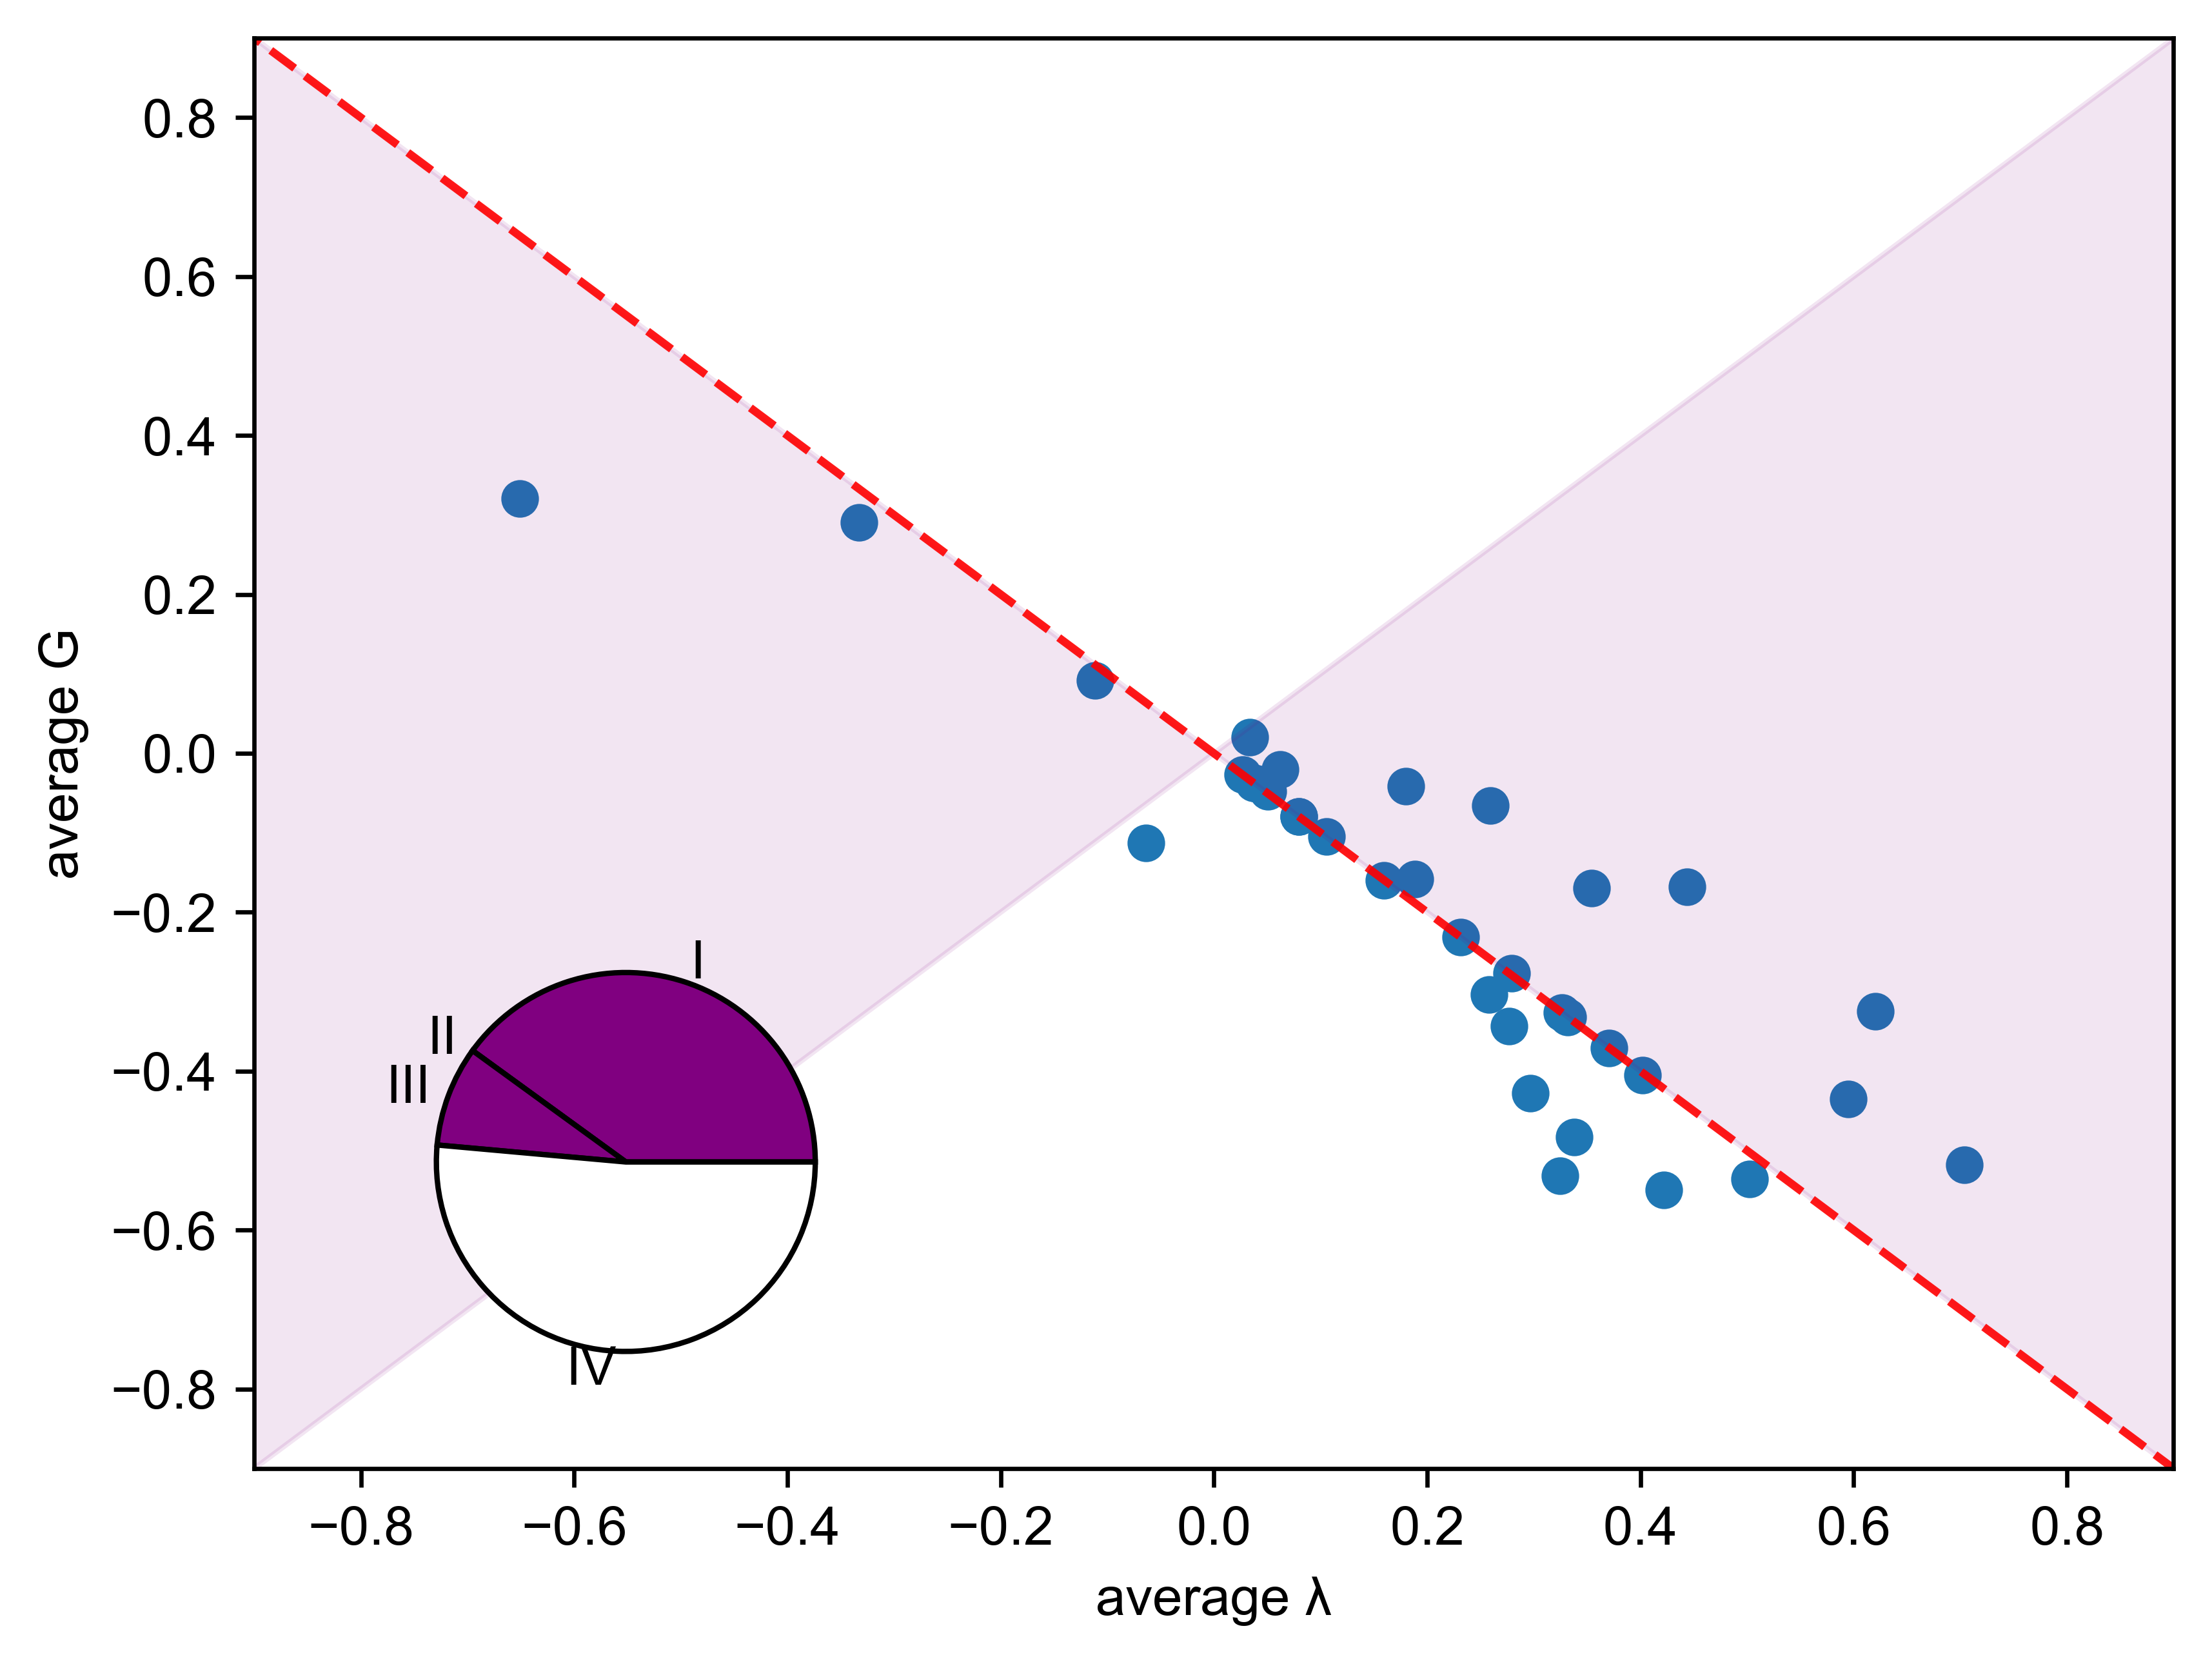

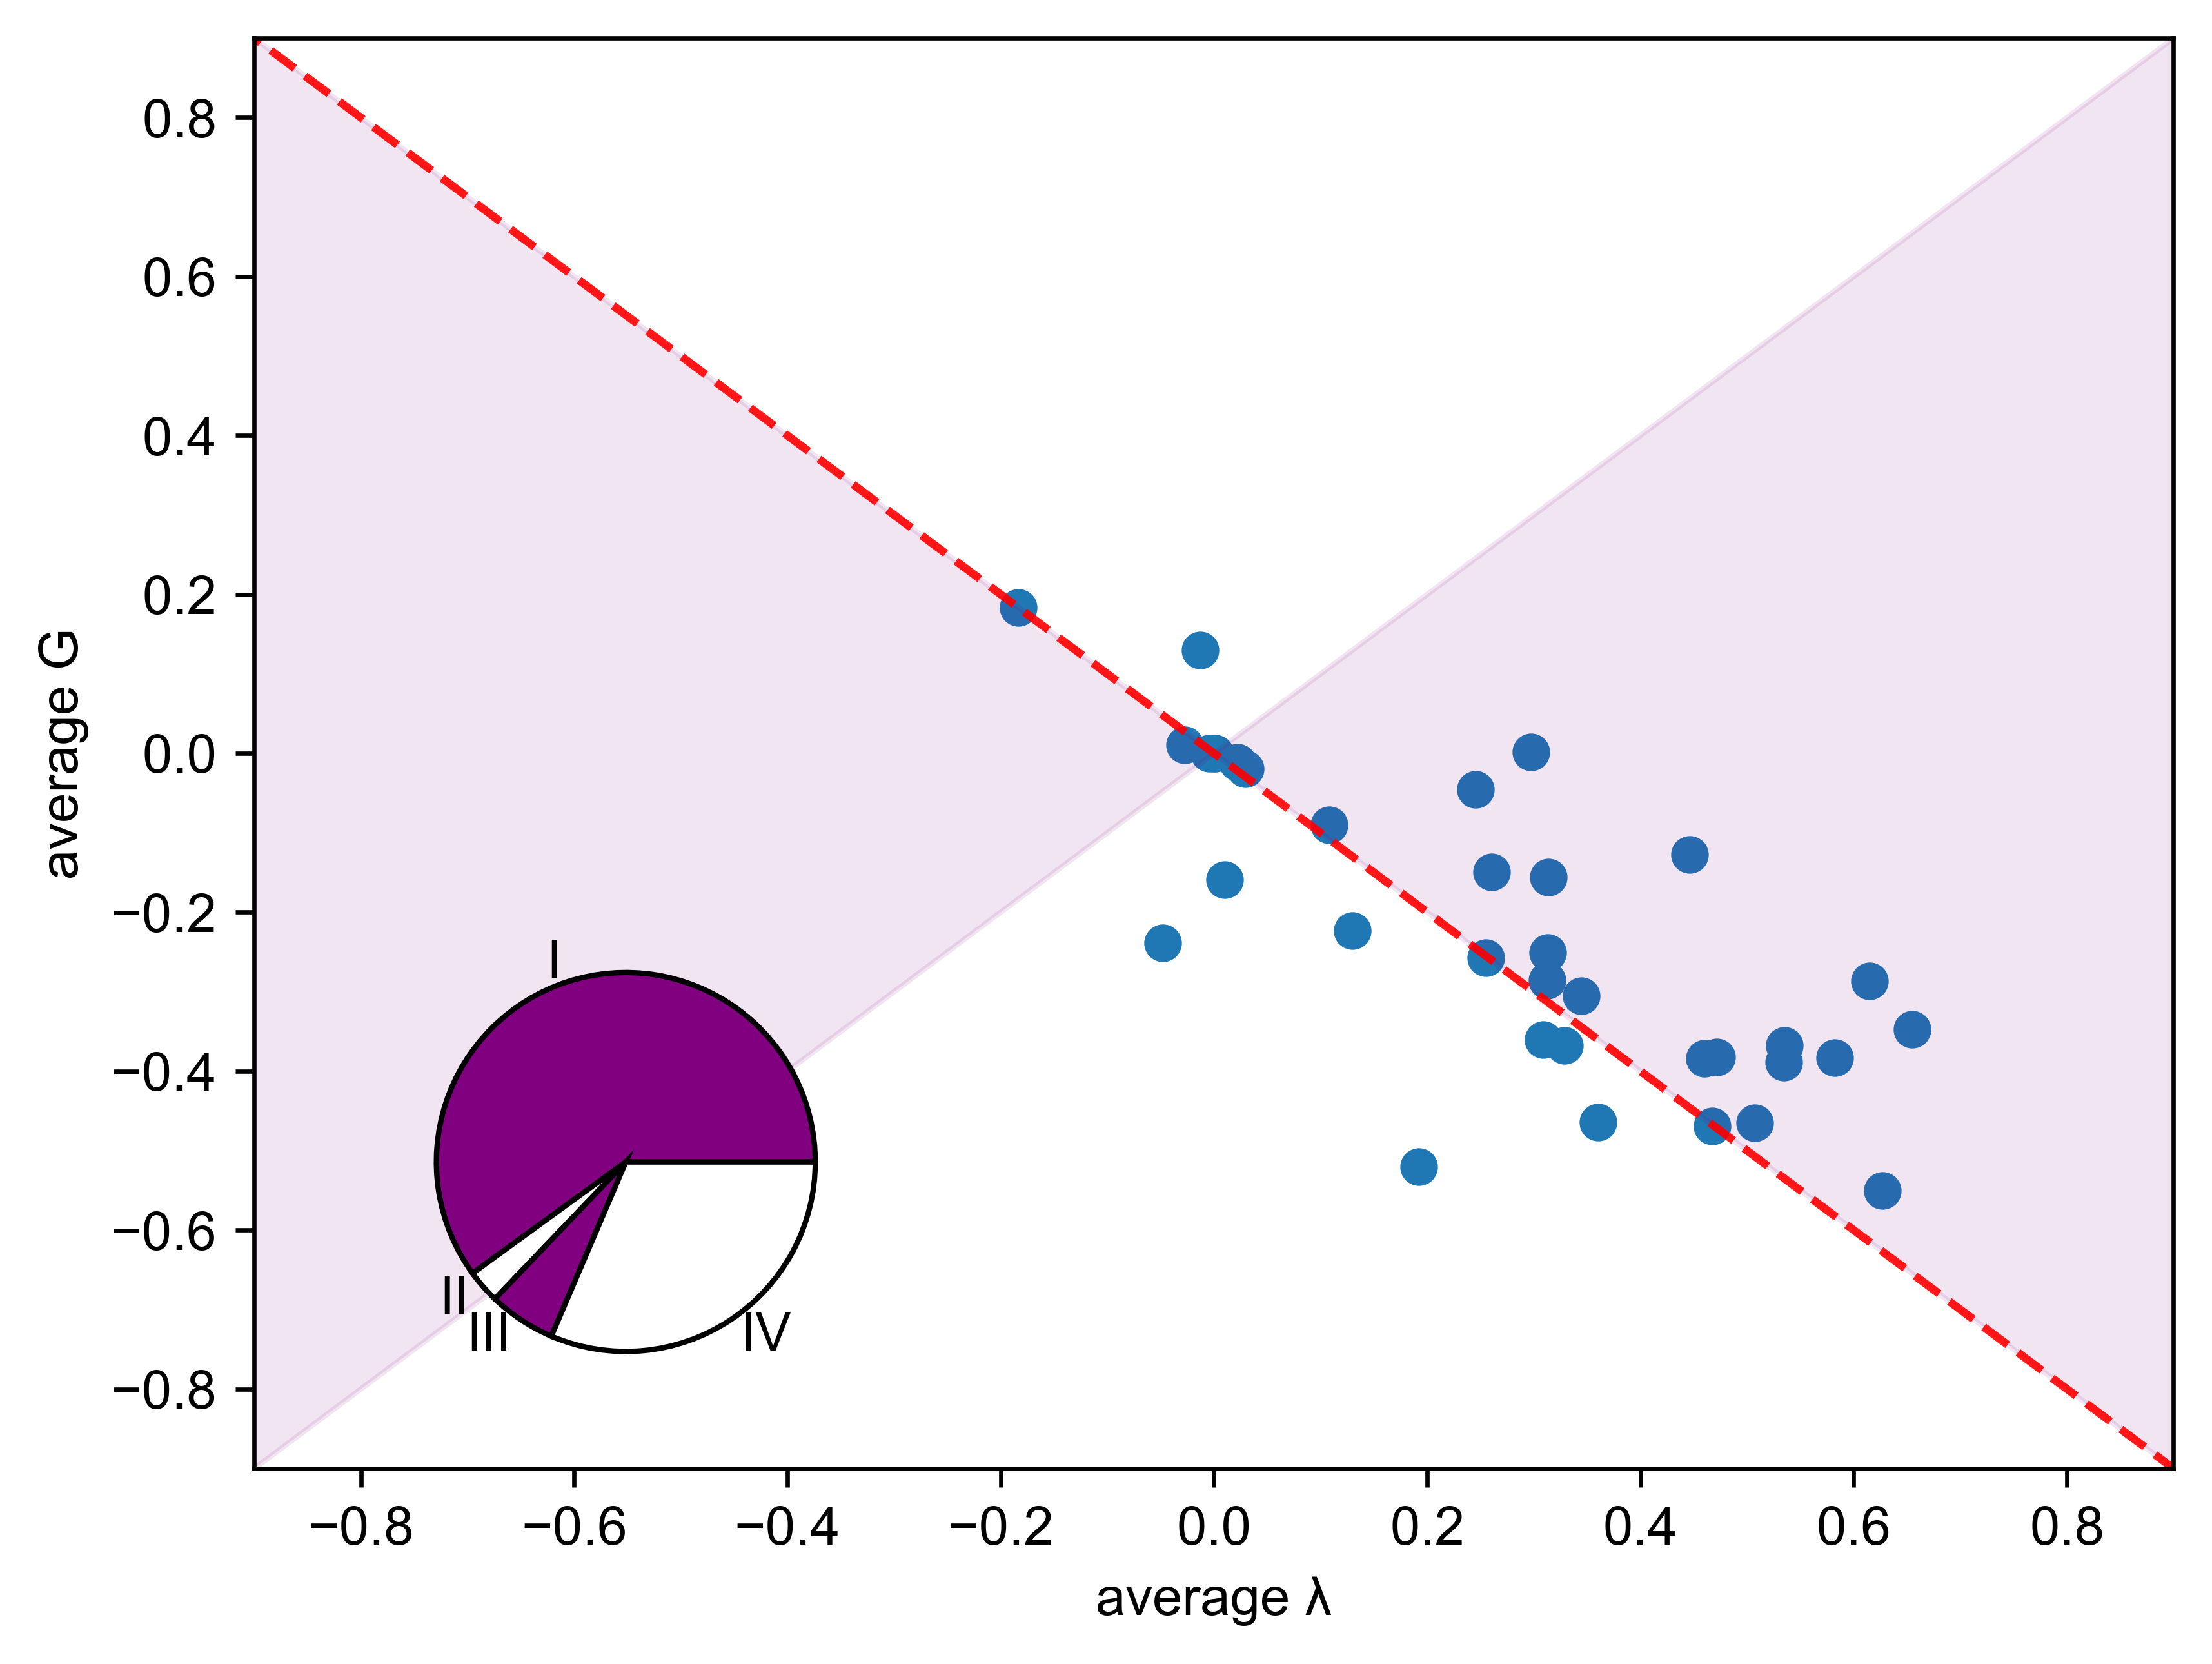

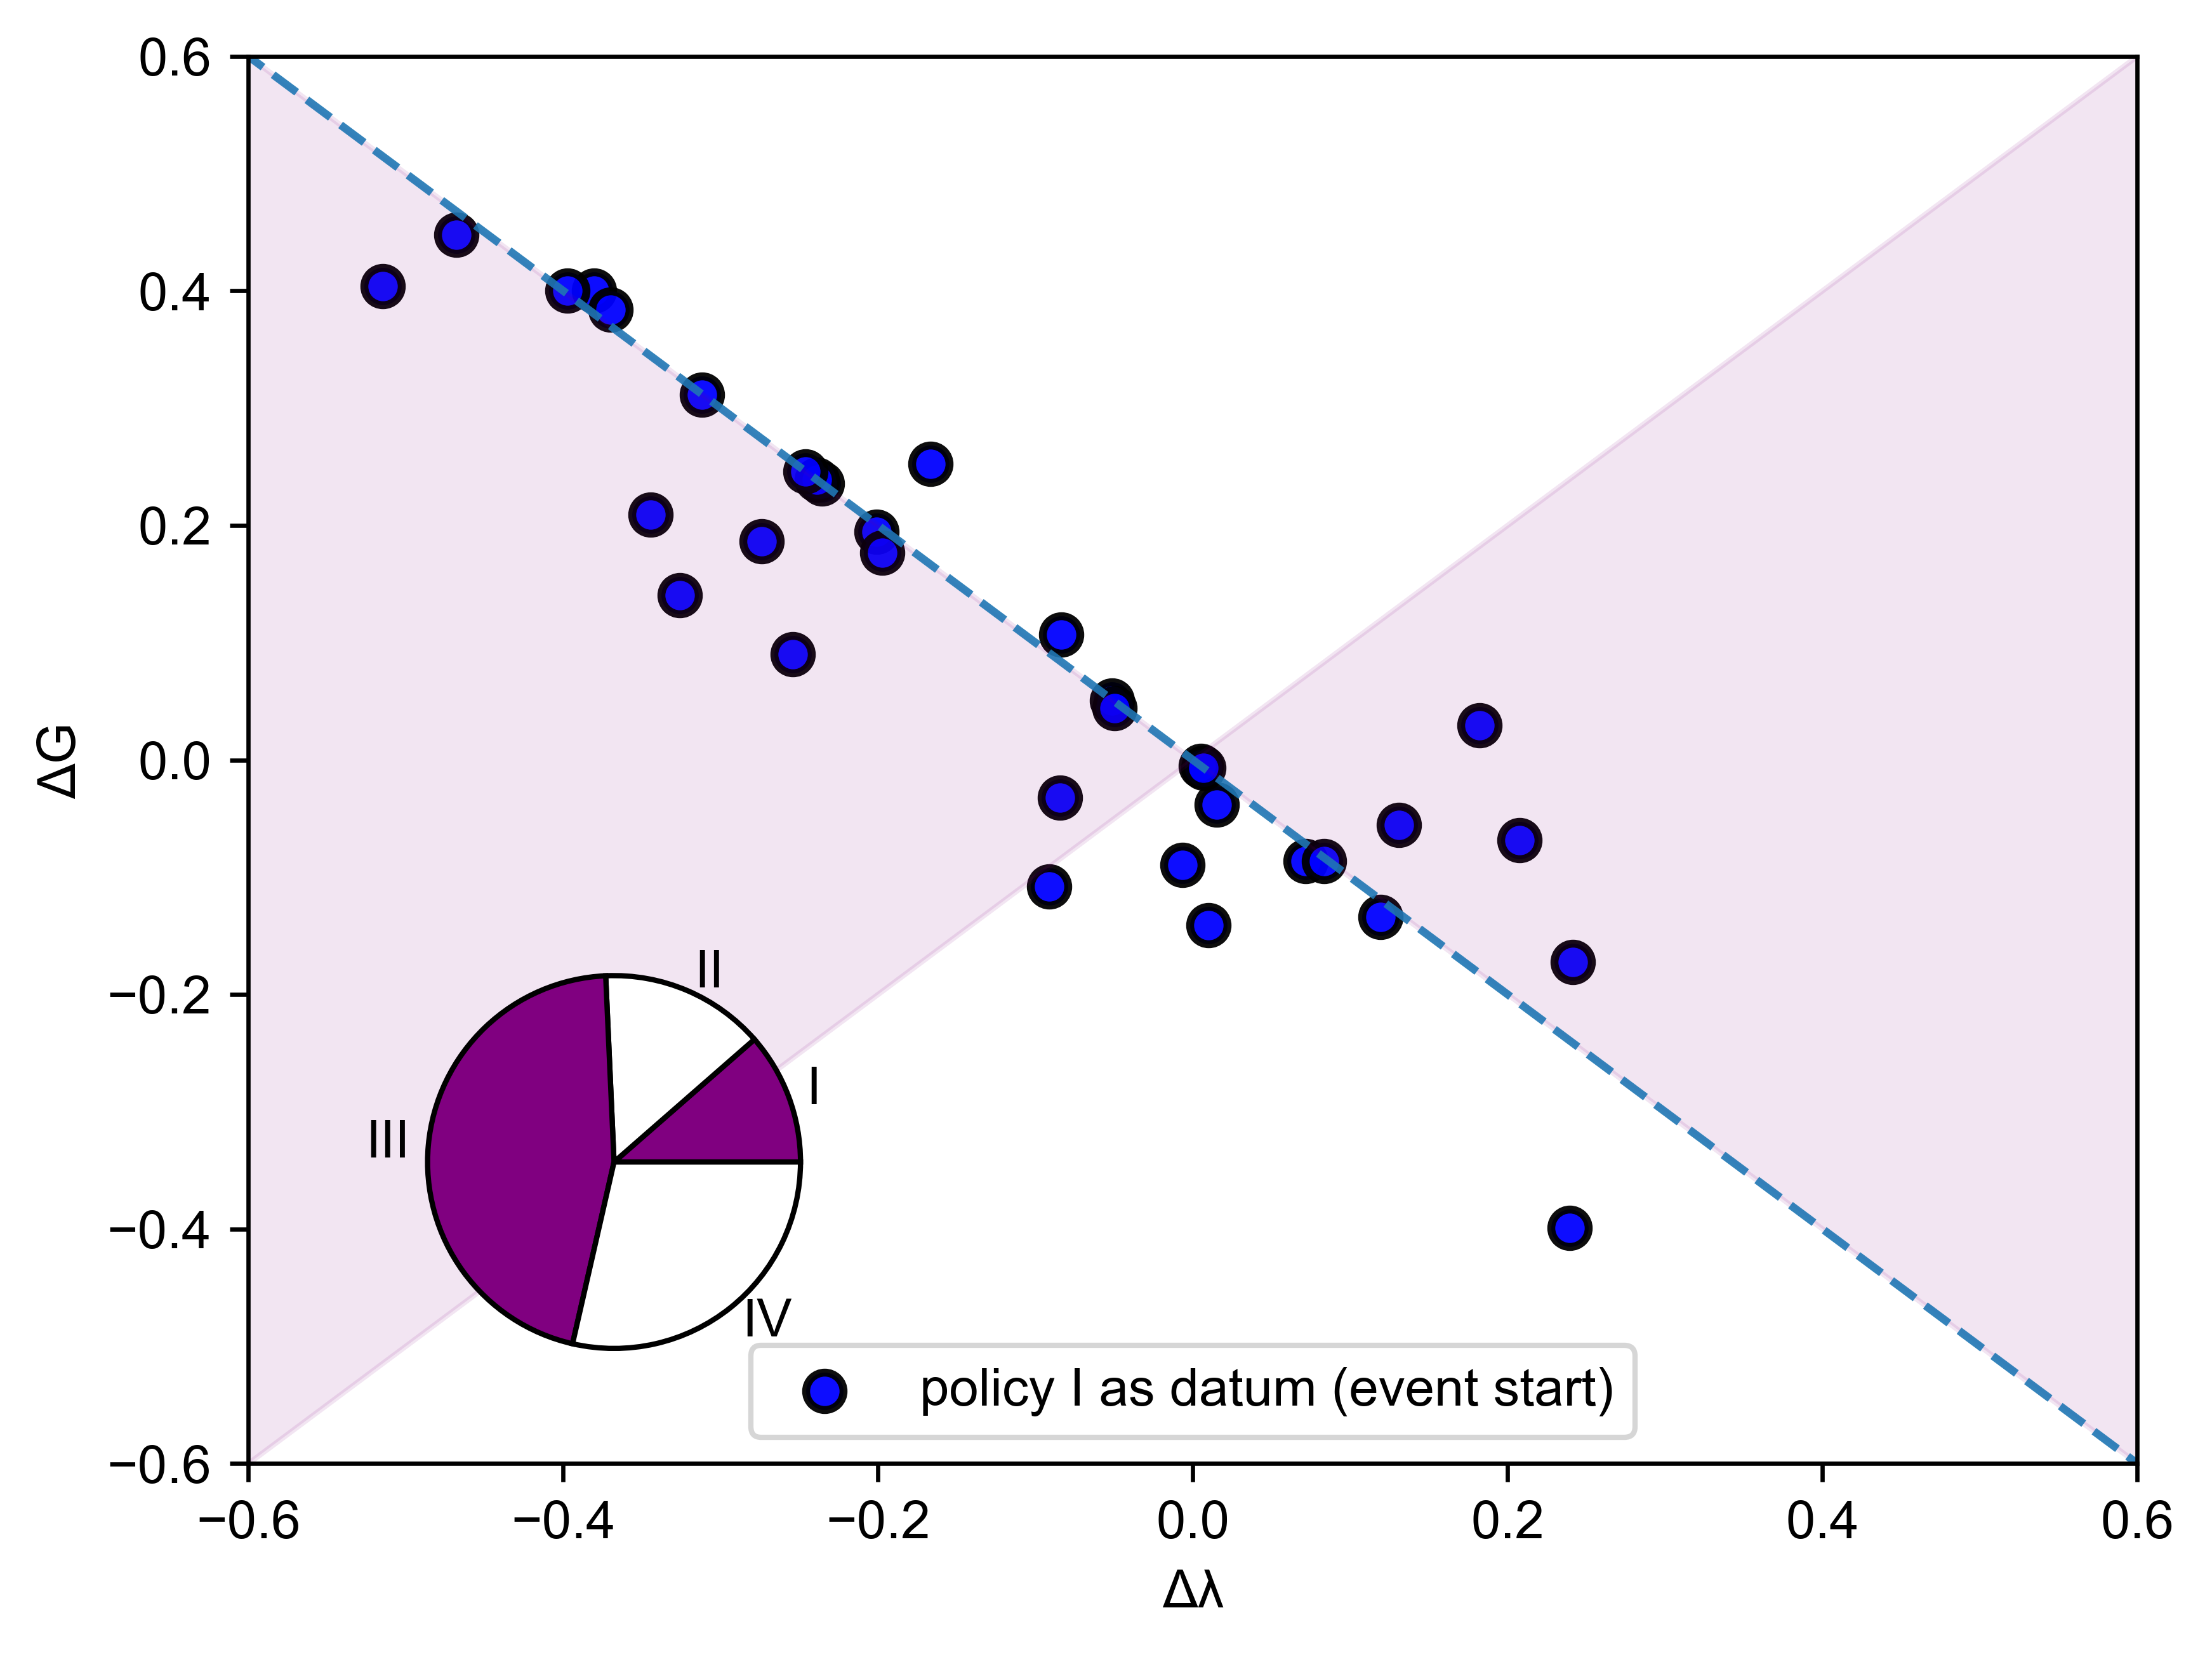

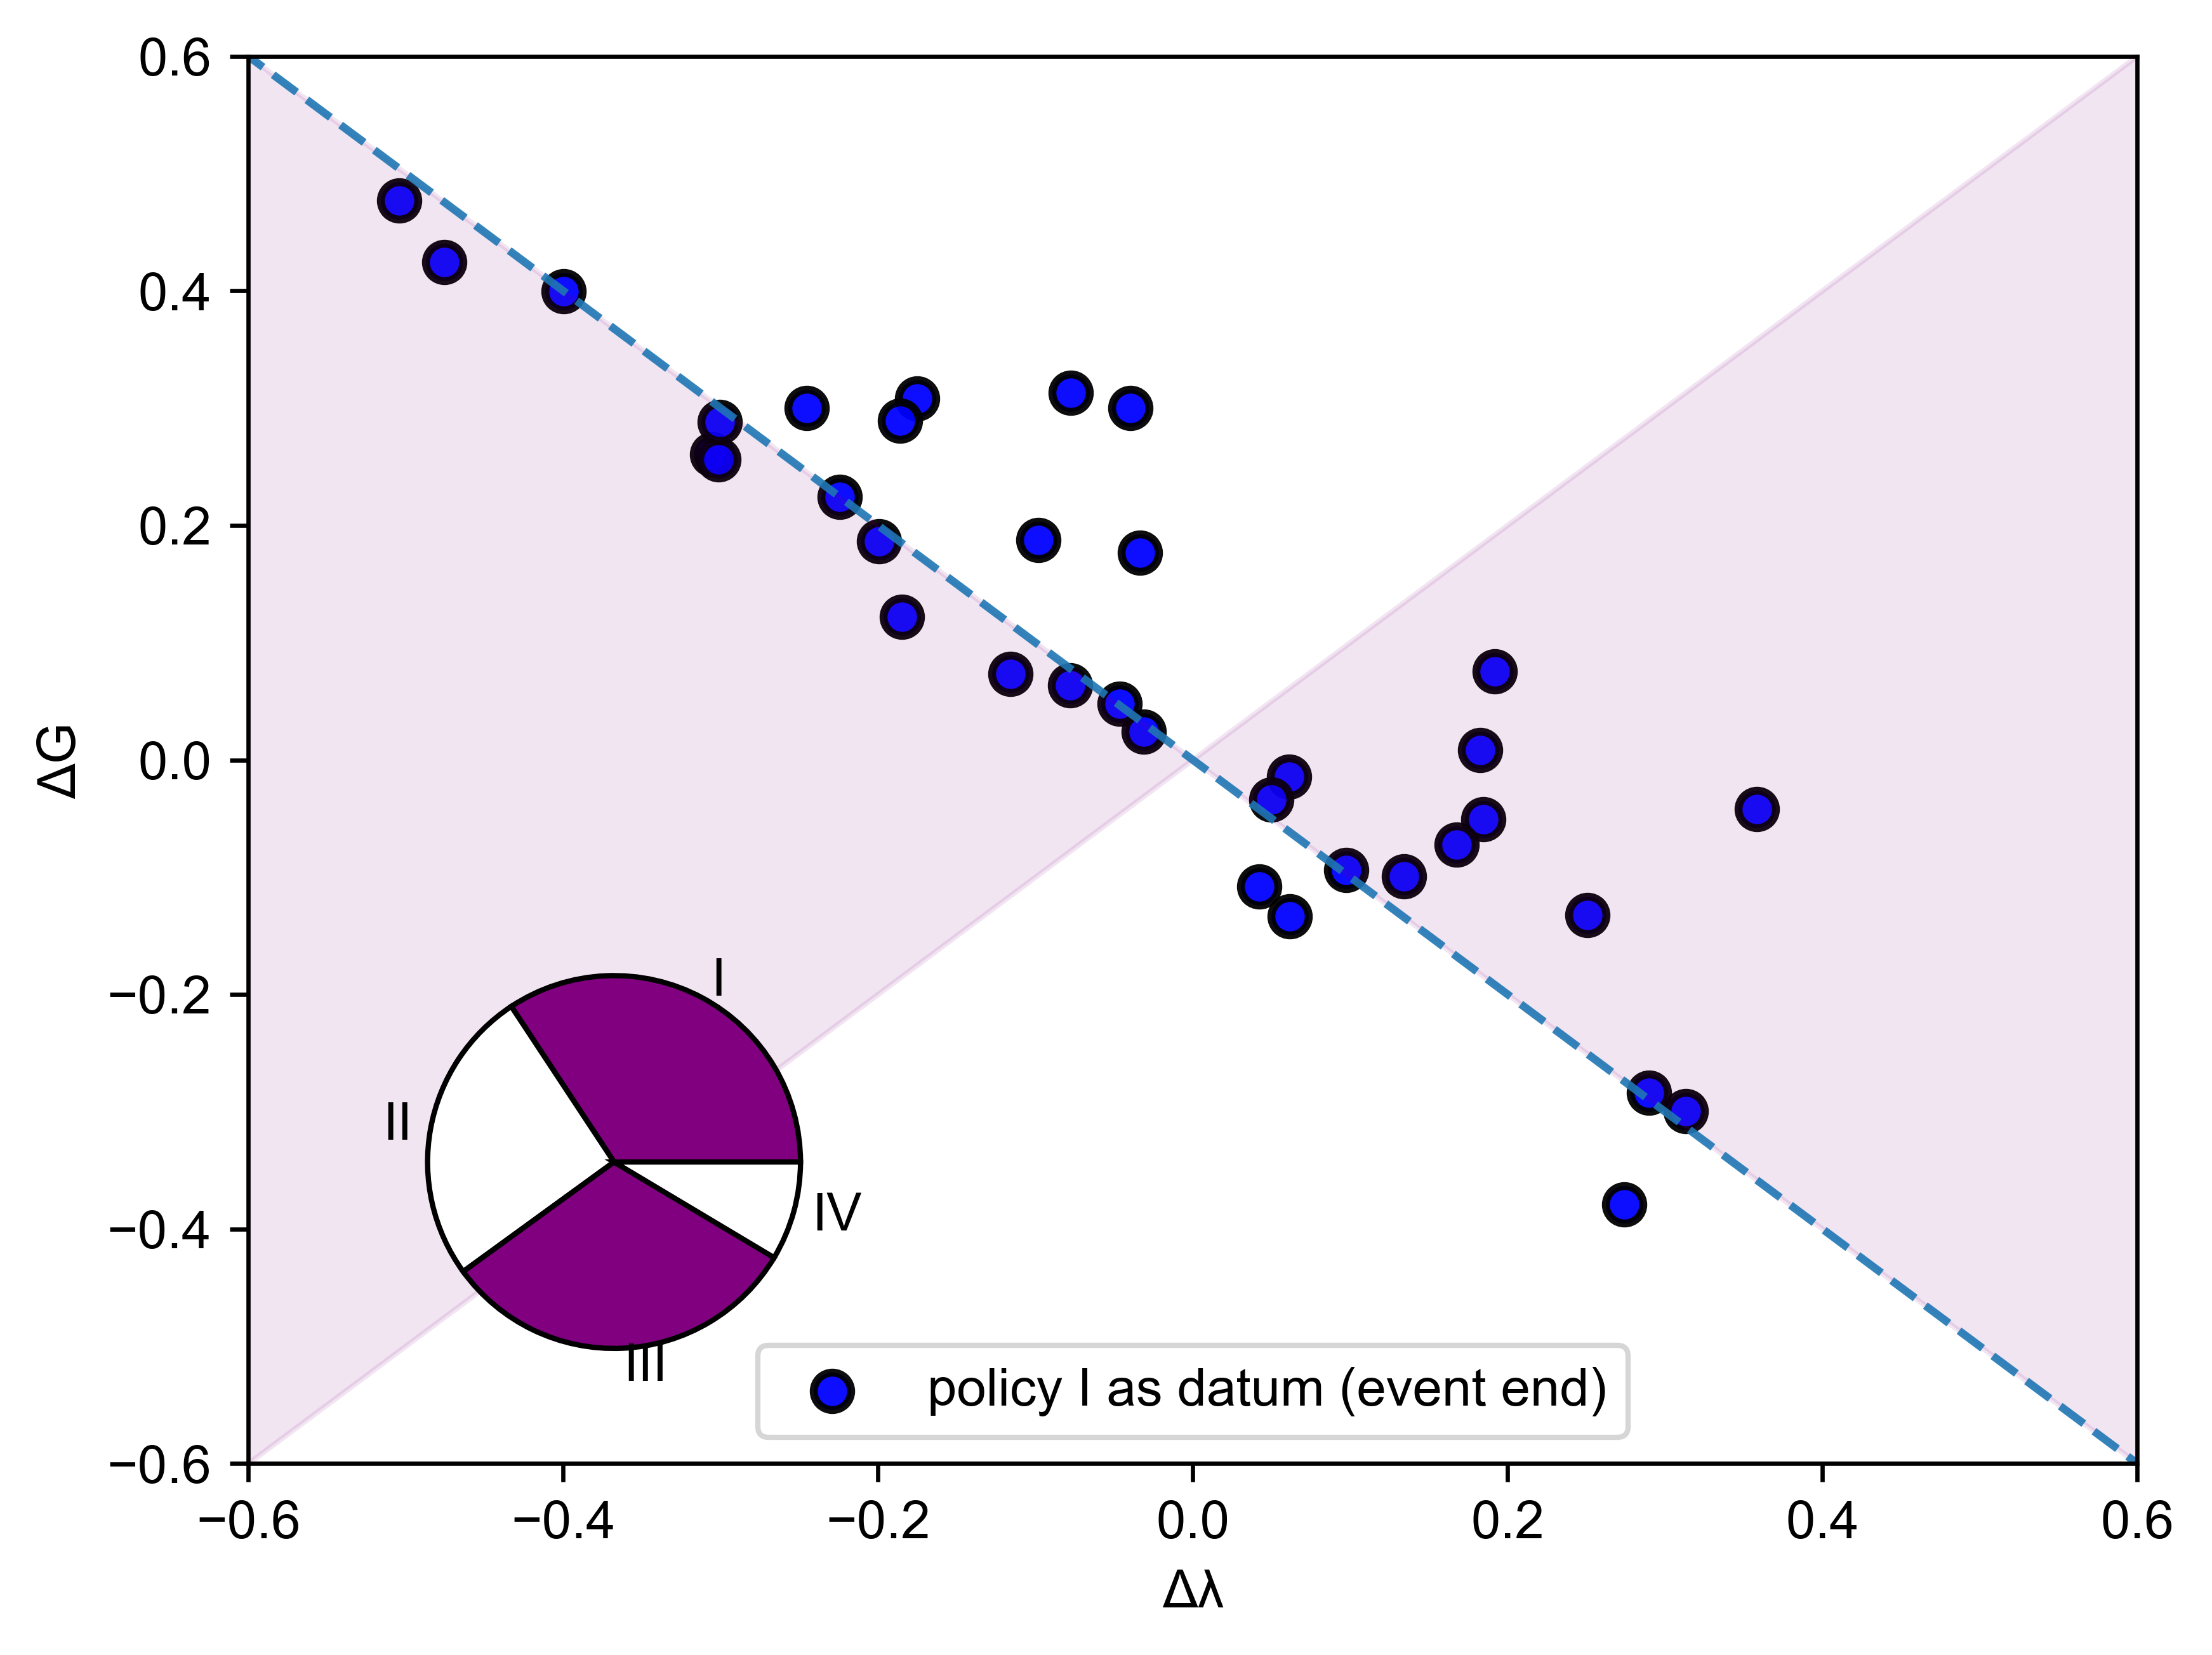

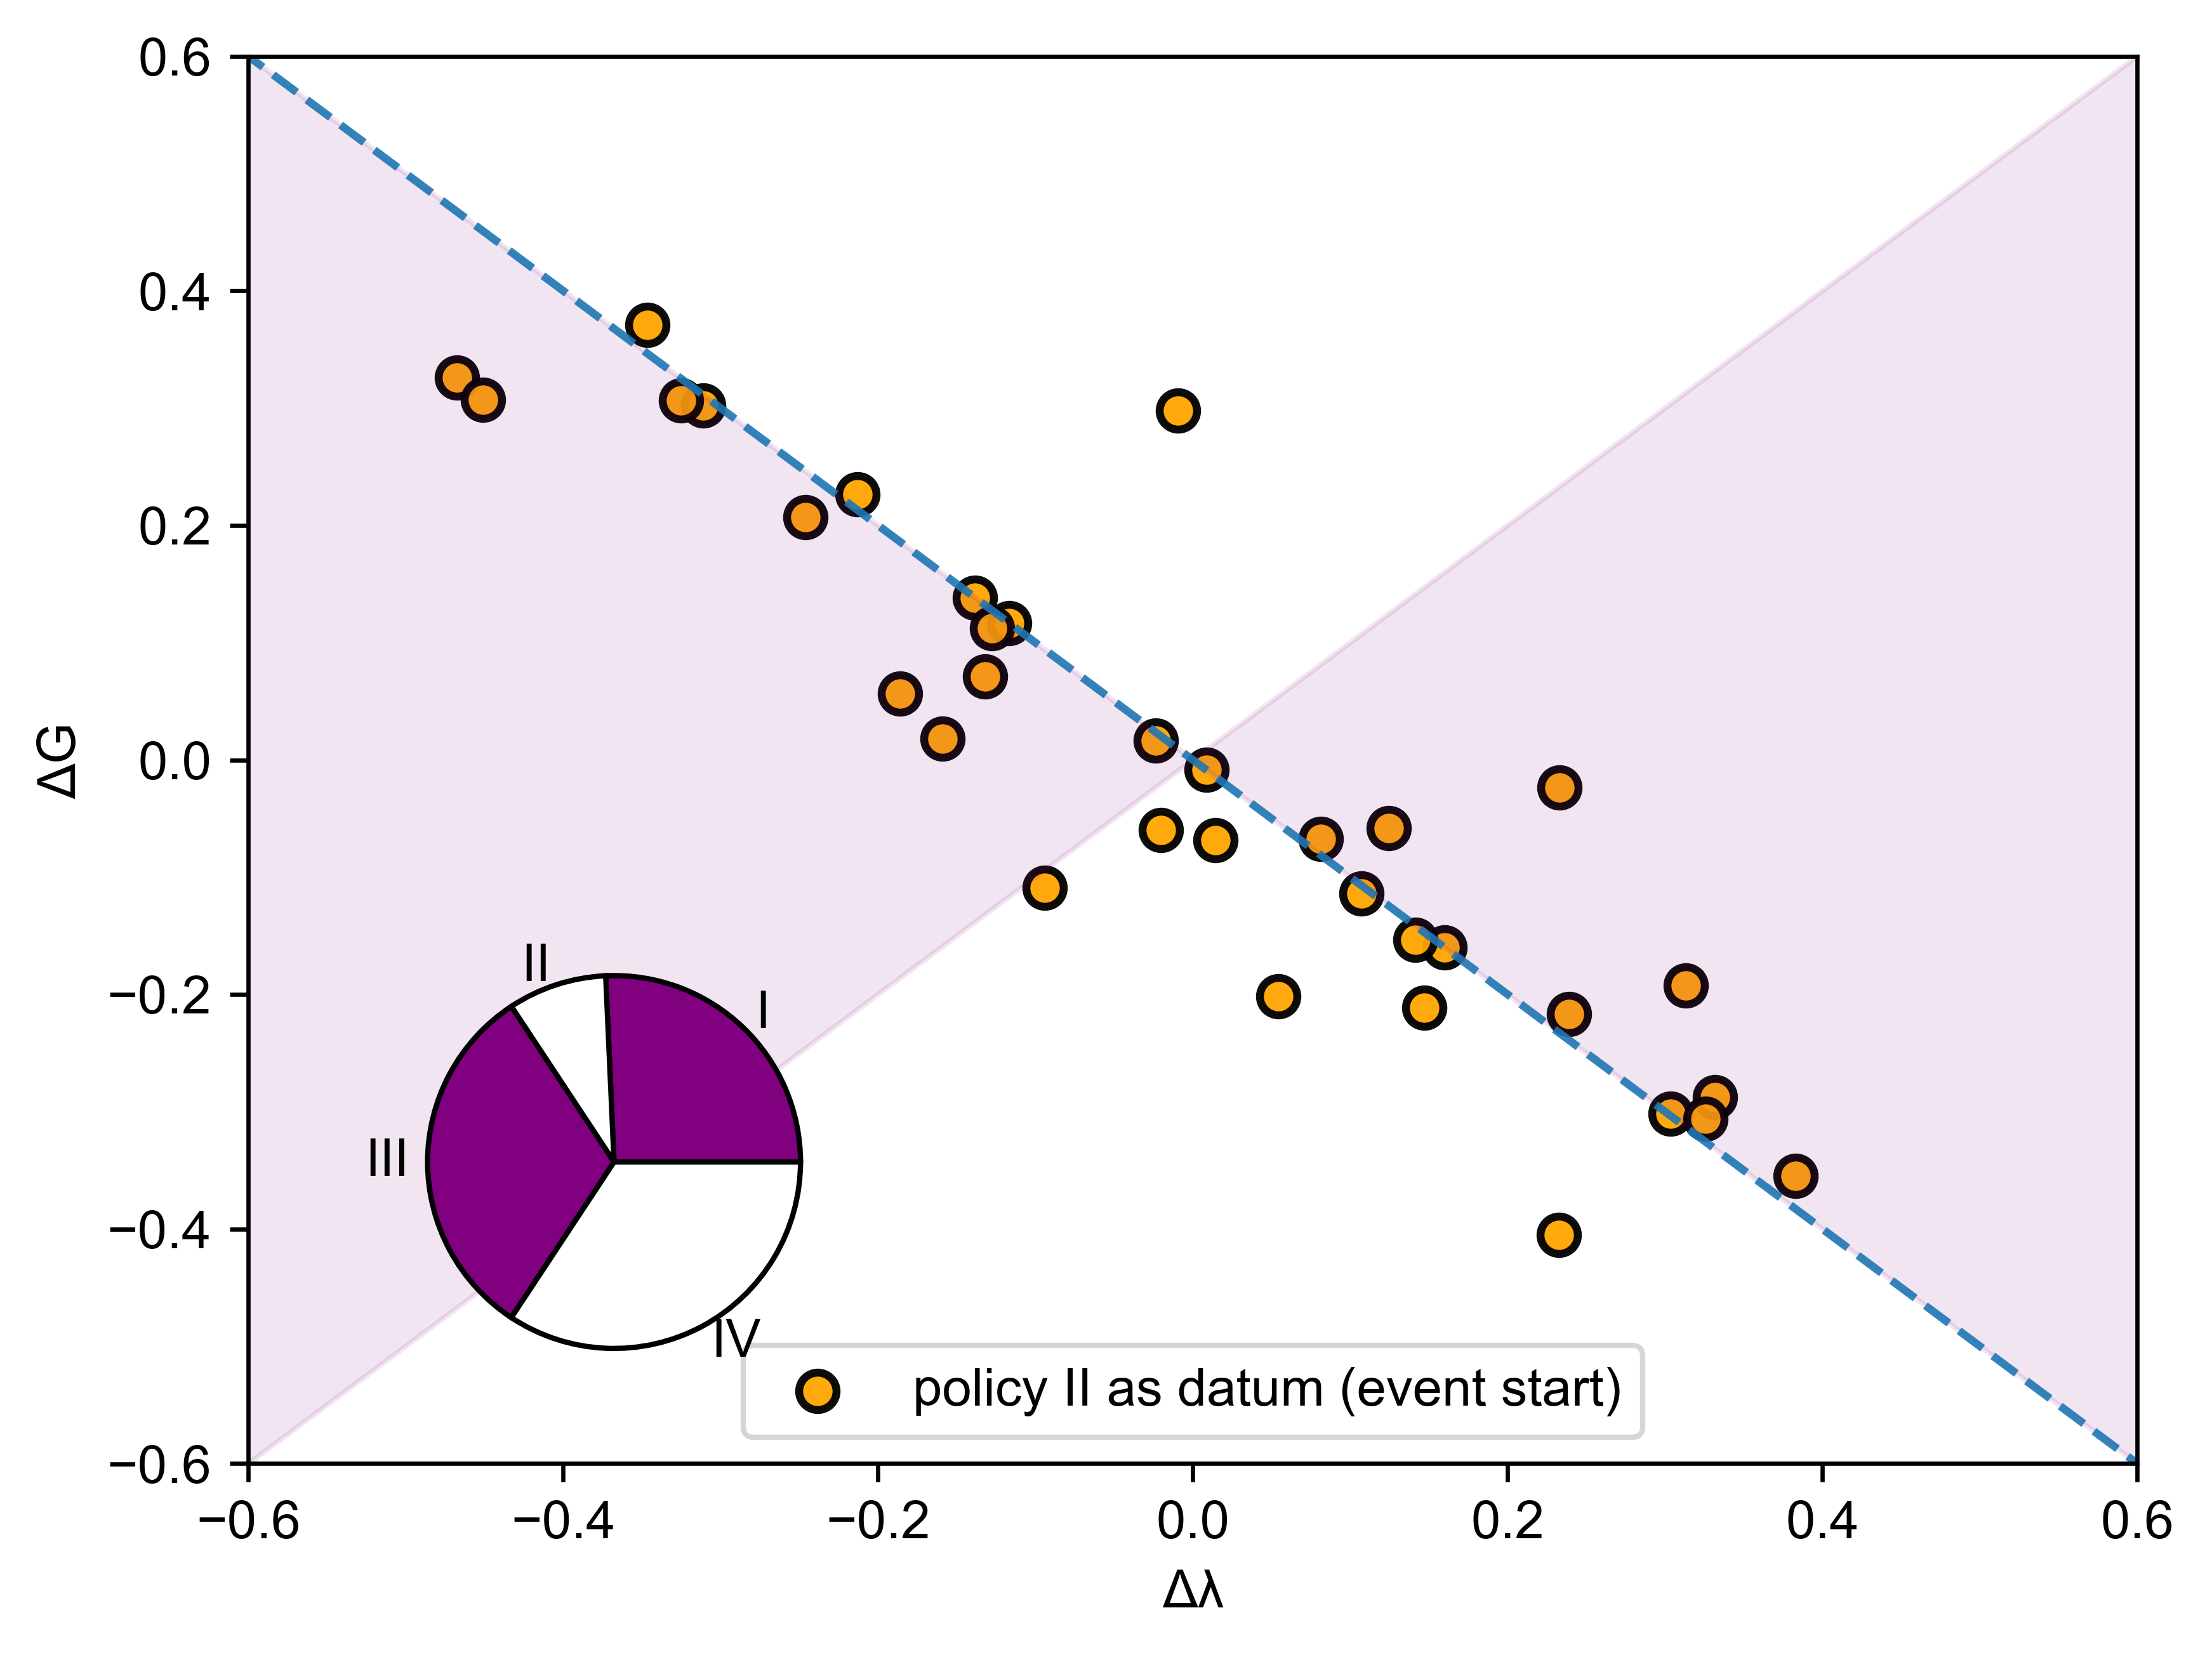

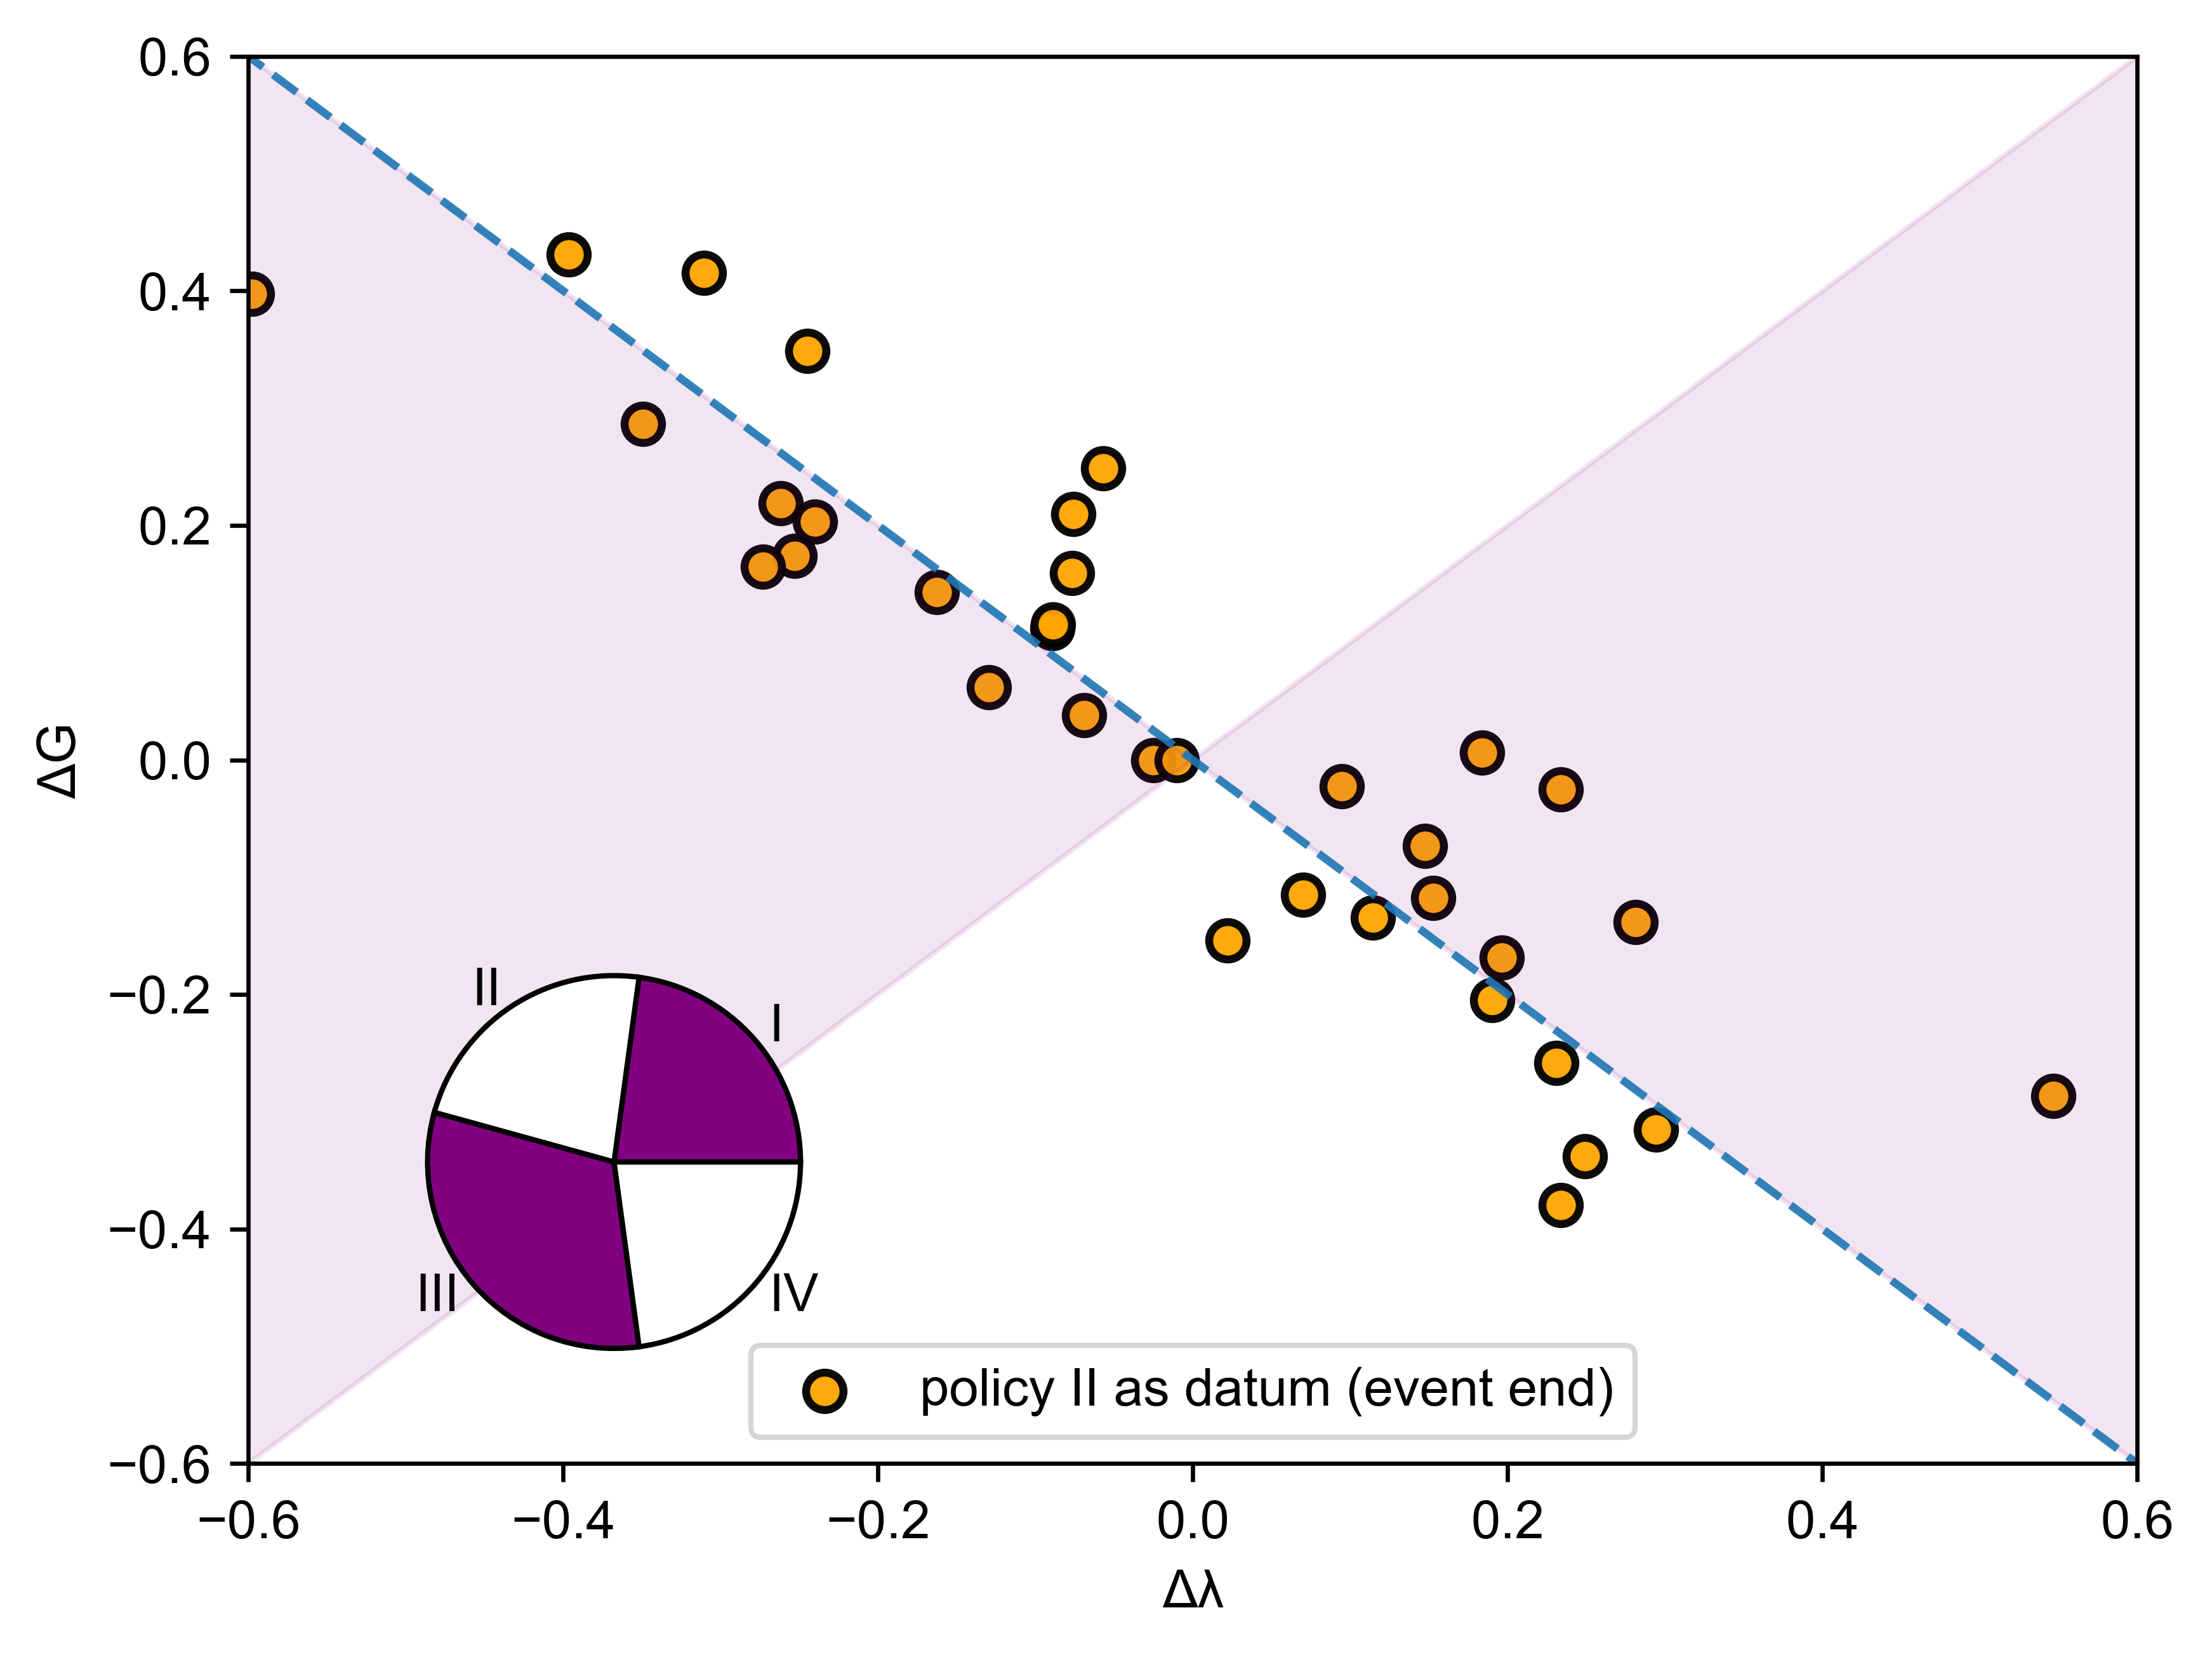

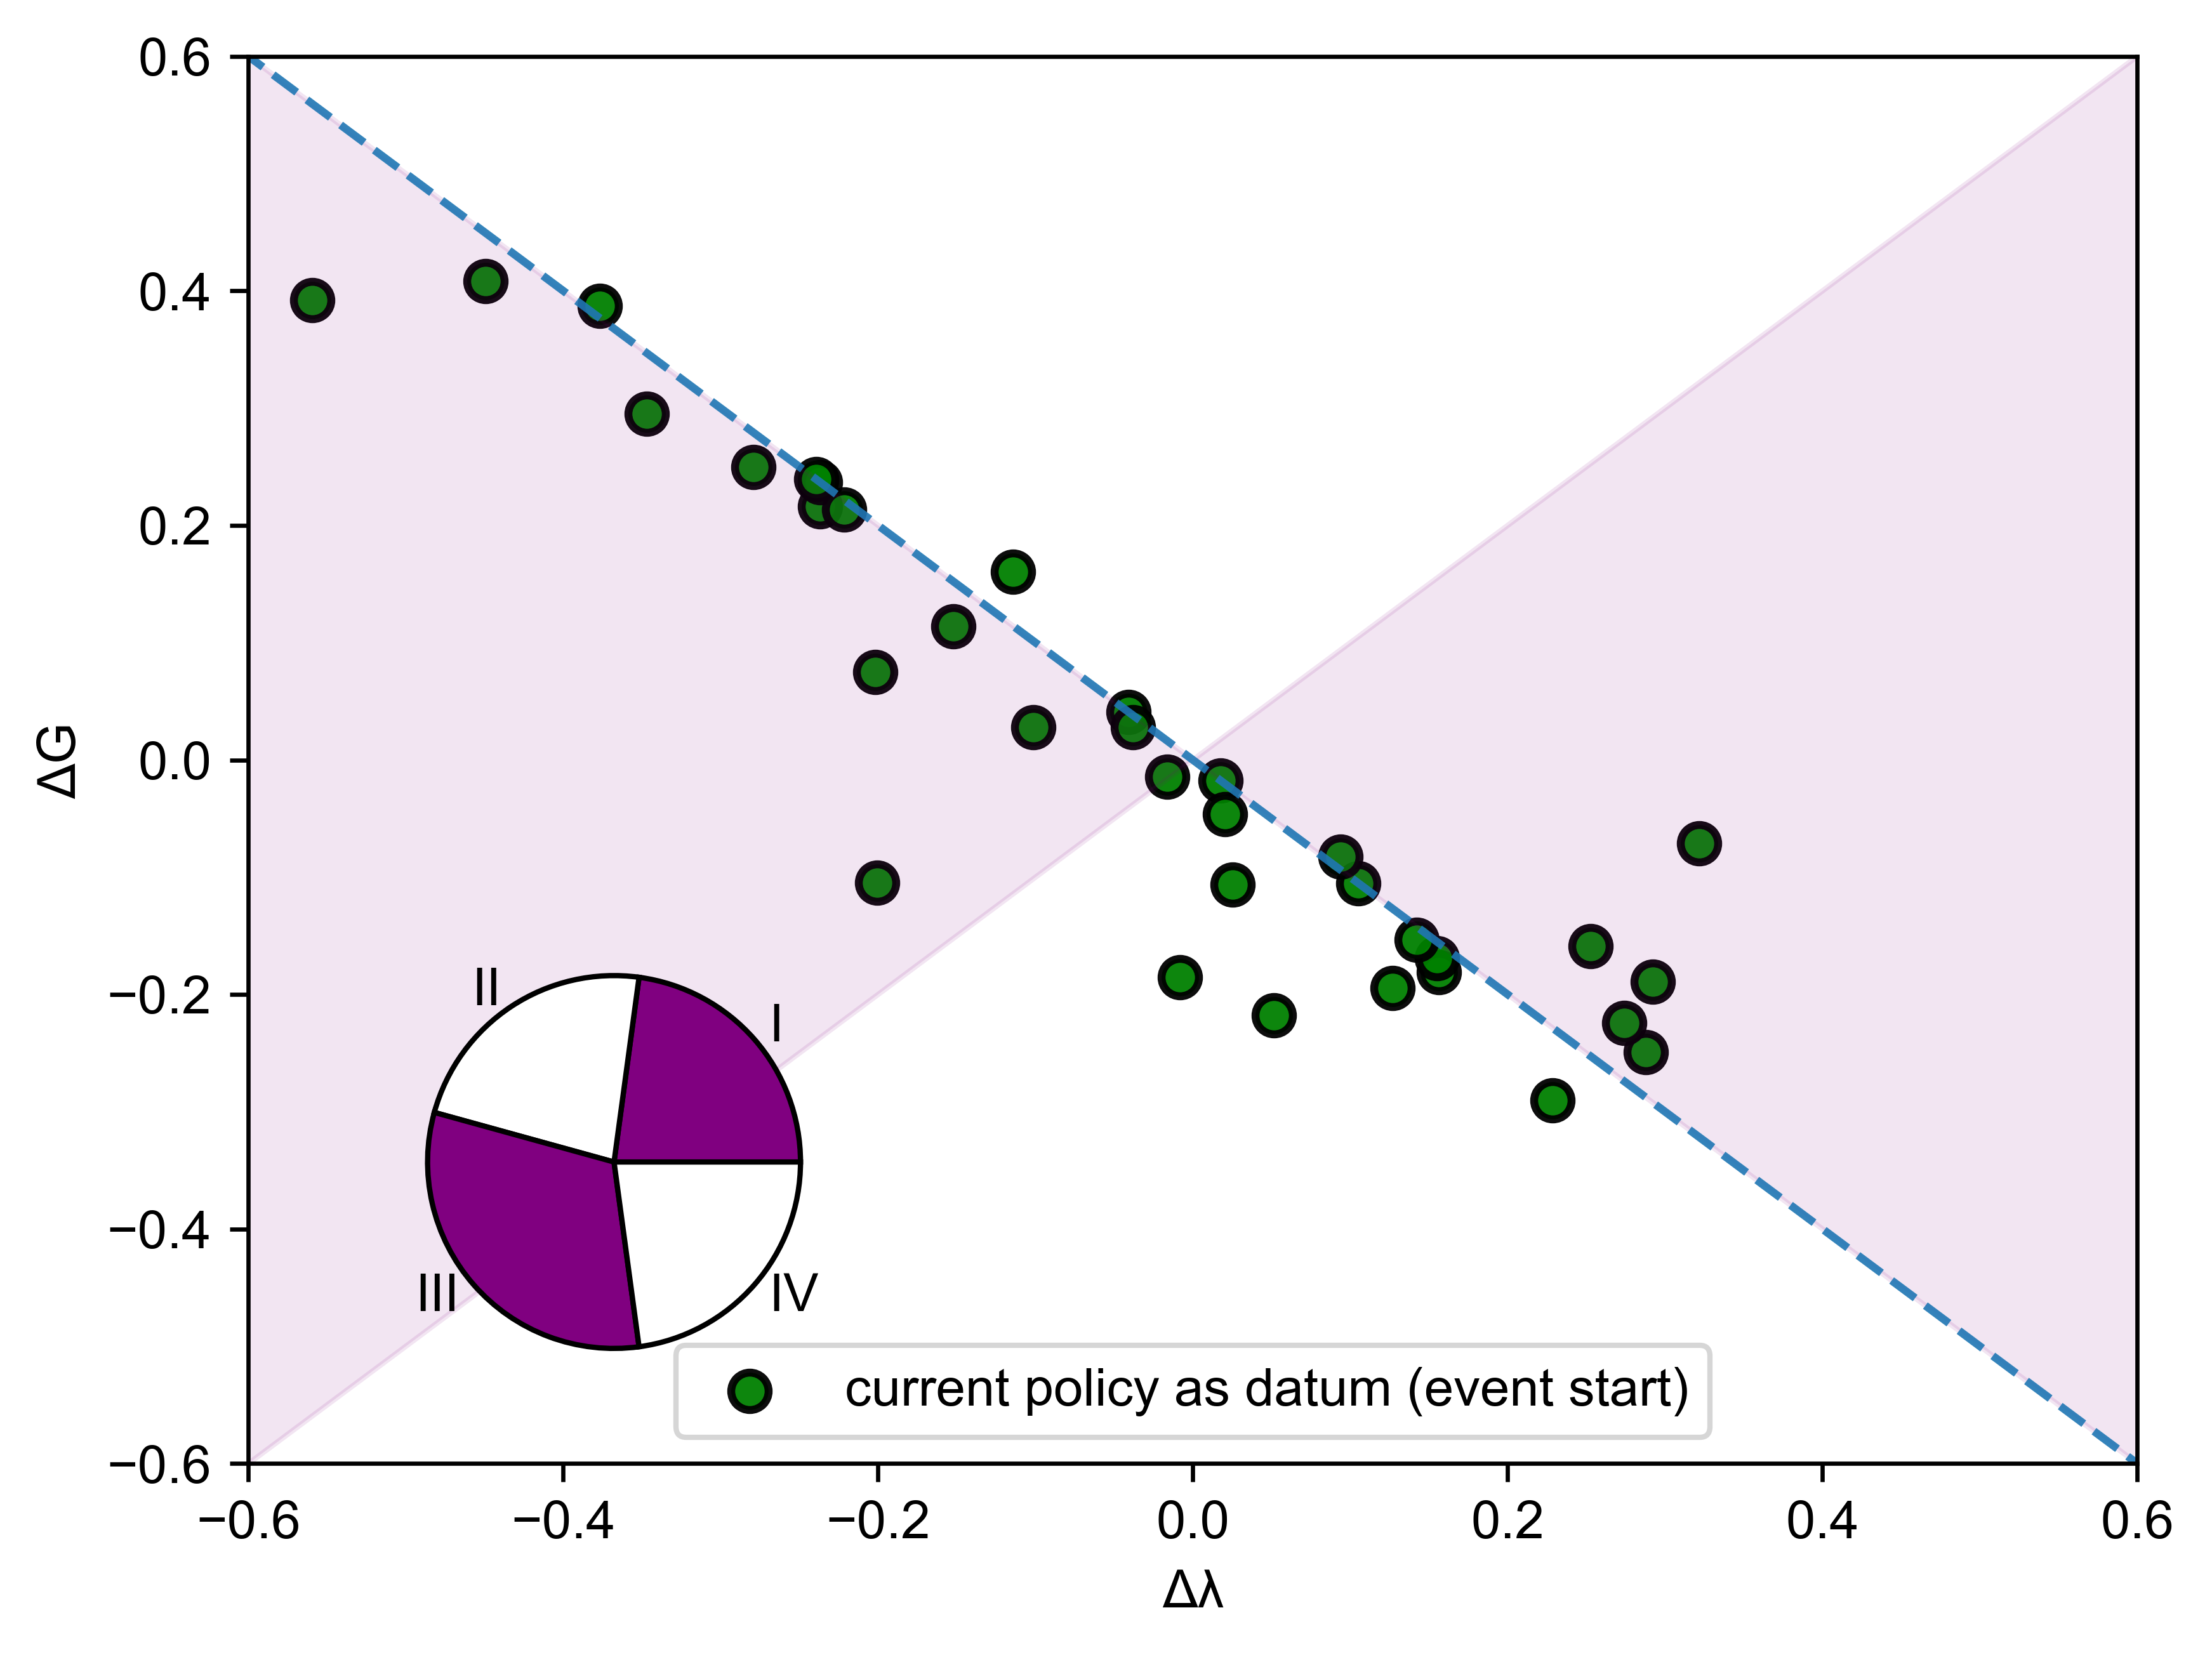

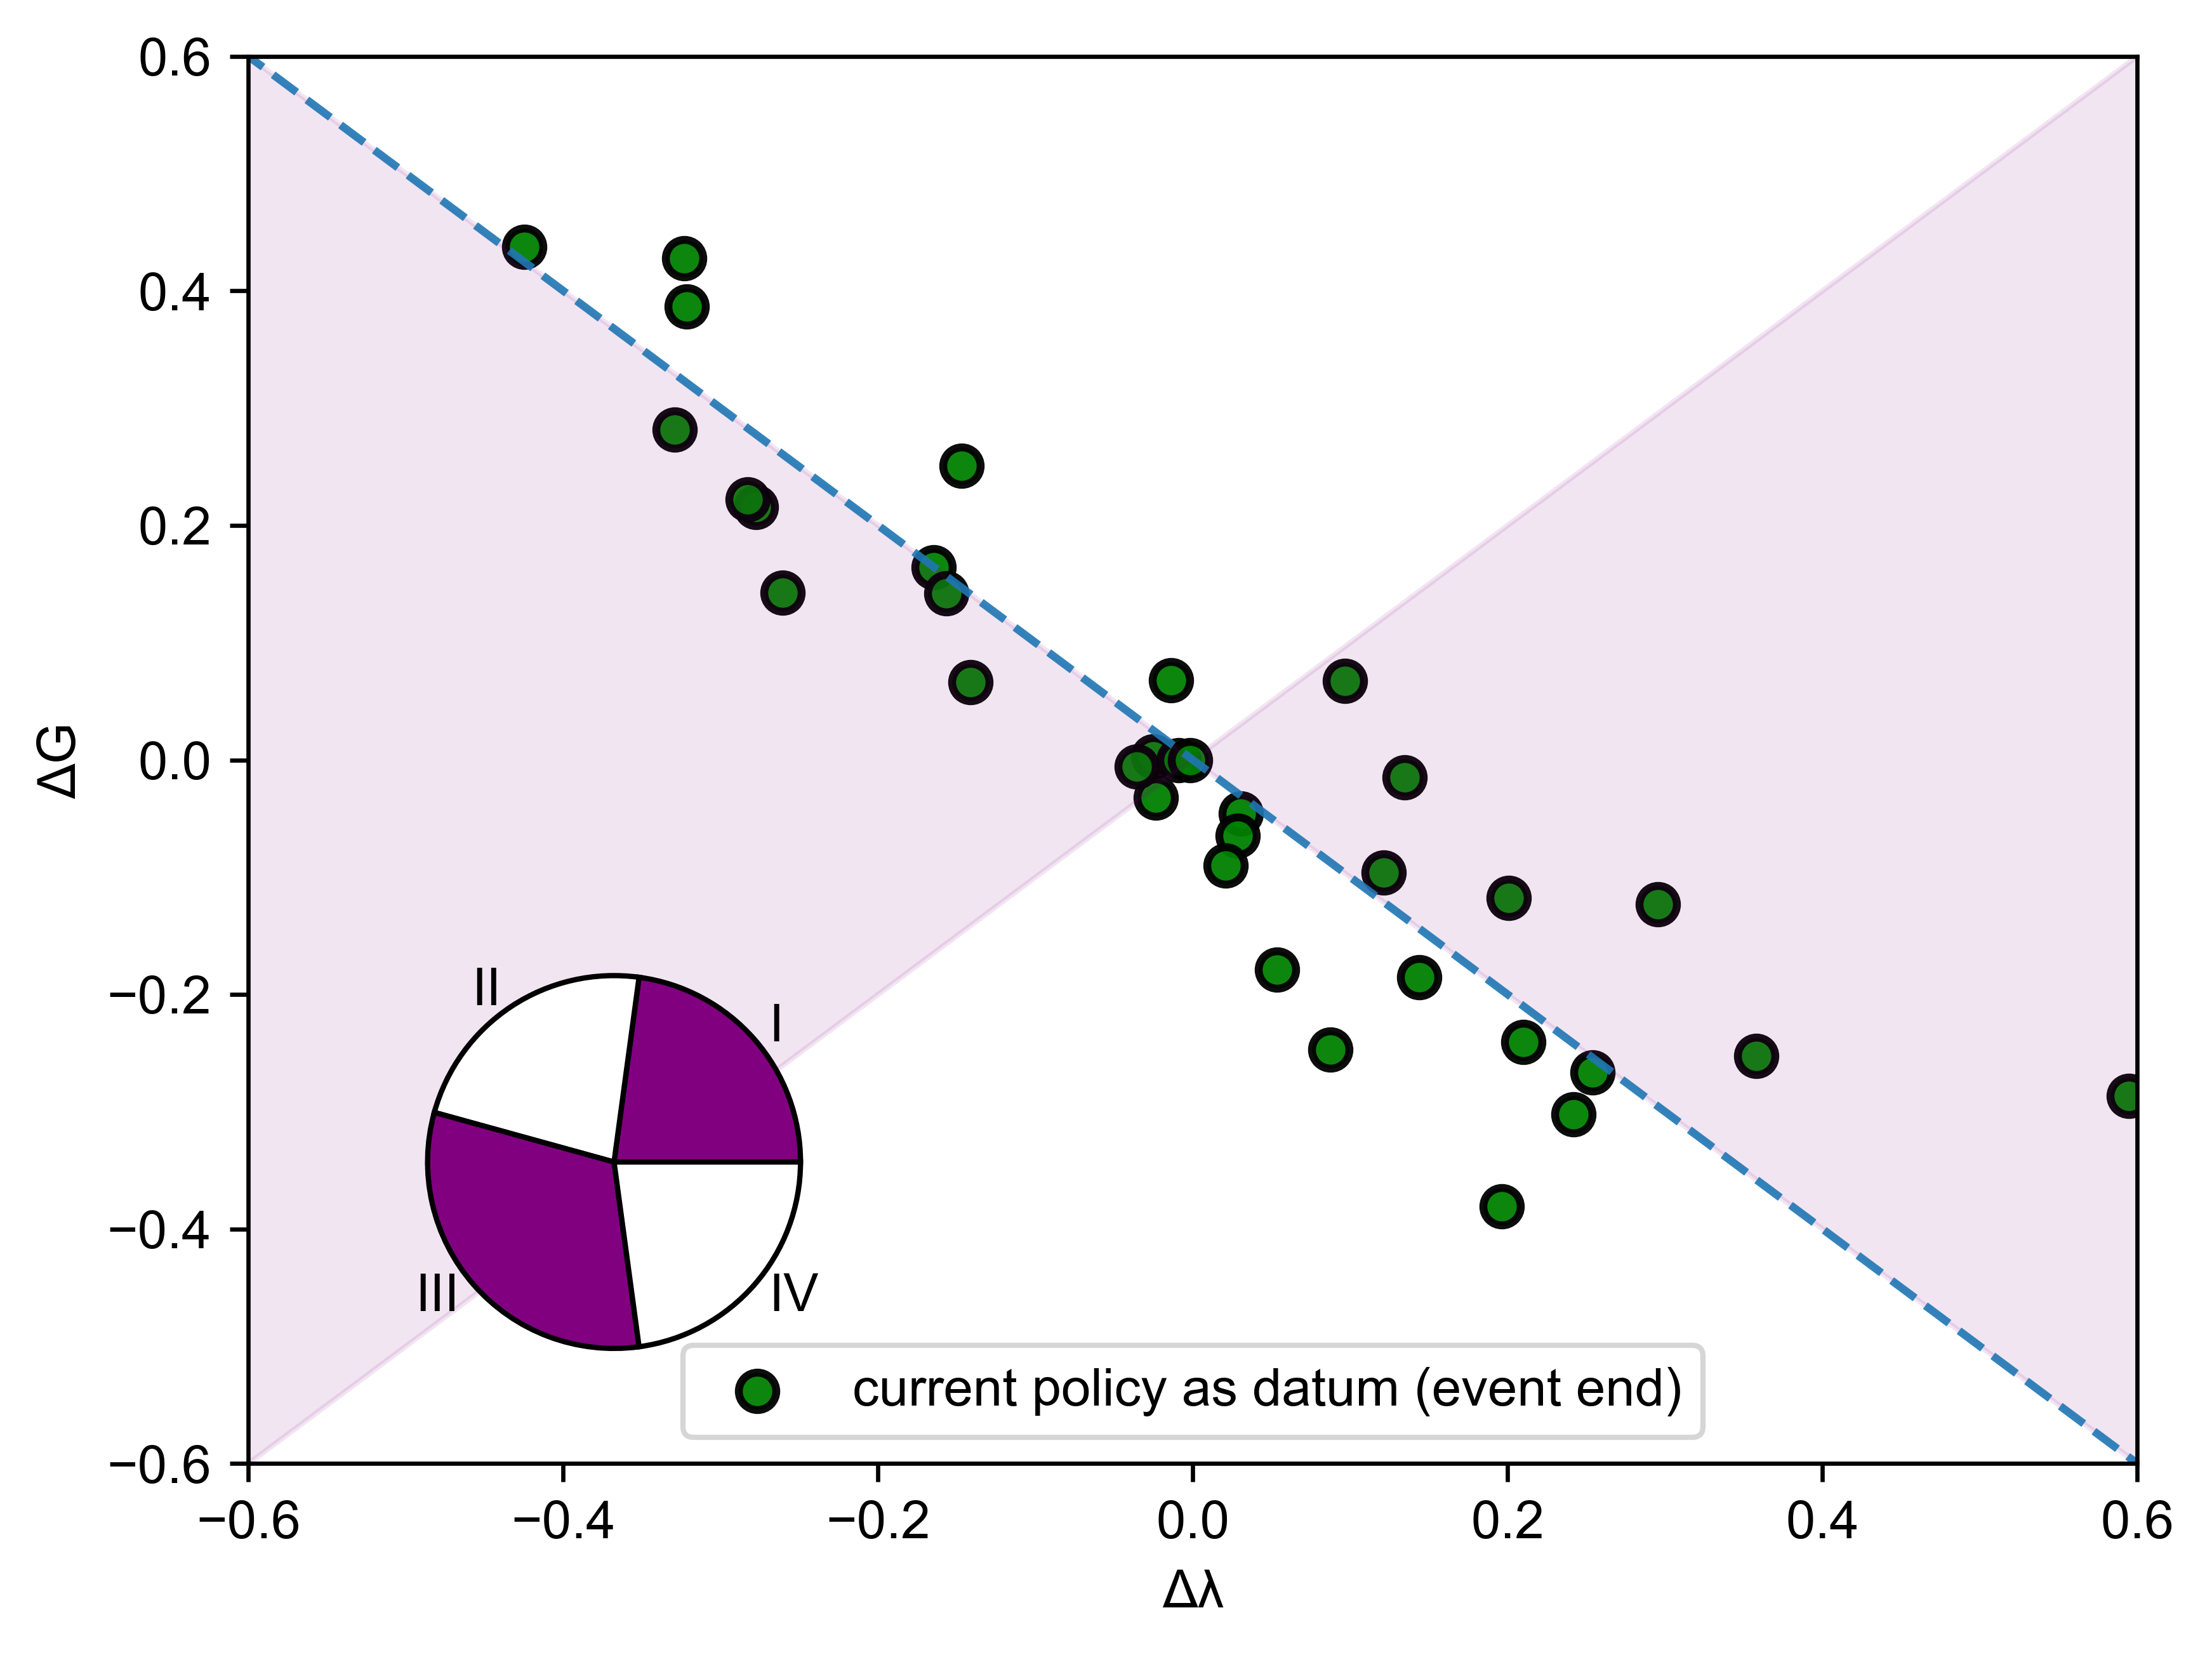

<Figure size 3840x2880 with 0 Axes>

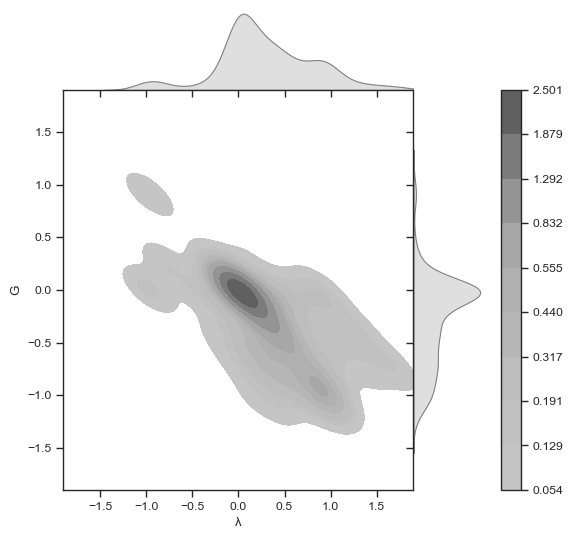

<Figure size 3840x2880 with 0 Axes>

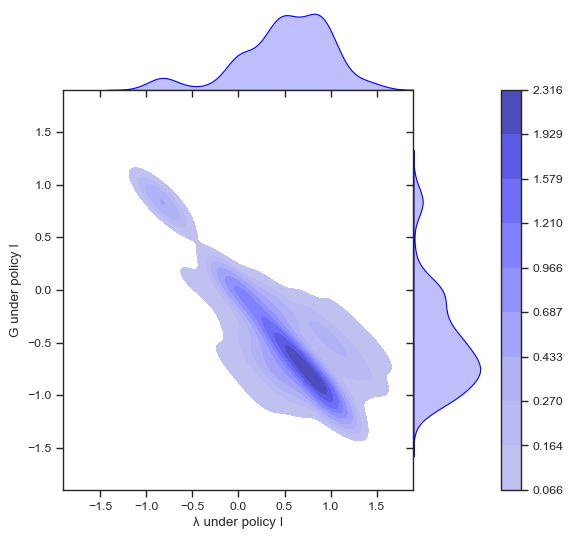

<Figure size 3840x2880 with 0 Axes>

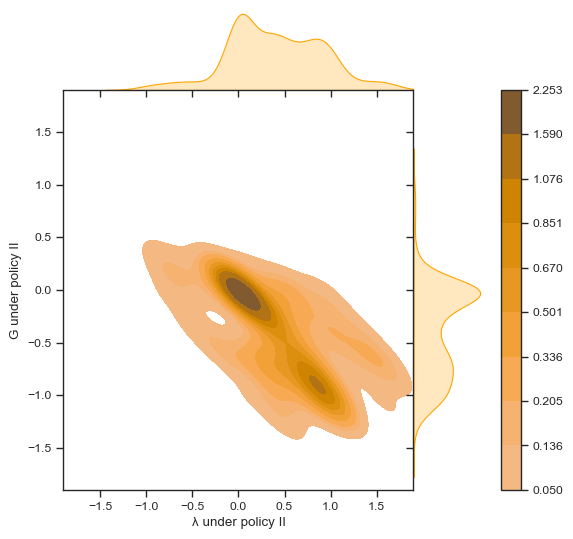

<Figure size 3840x2880 with 0 Axes>

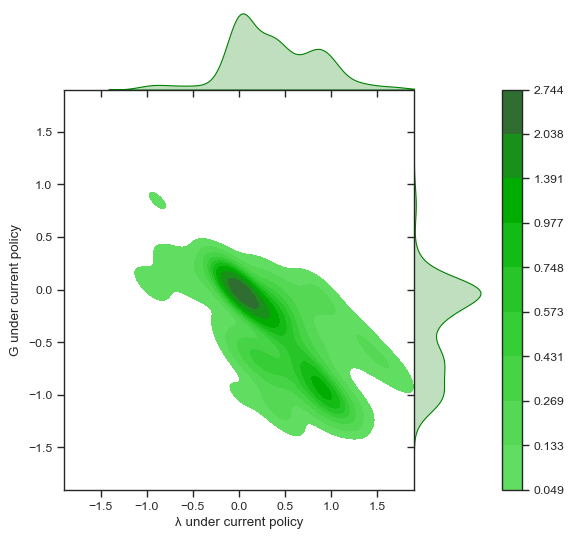

In [1]:
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import matplotlib.cm as cm
import learn_ar_model as lm
from matplotlib import gridspec
import seaborn as sns

file_path_data_sheet = './data/data_sheet.xlsx'
file_path_tem = './data/石門站溫度資料.txt'
file_path_total_data = './data/石門水庫雨量與流量資料.xlsx'
file_path_ar = './data/日雨量溫度資料.xlsx'
file_path_riskmap_p = "./data/"
risk_map = lm.annual_riskmap
consumption_limit = 1500
max_storage = 3000
min_storage = 150
resolution = 20
discount_factors = [0.215, 0.465, 0.681]

df_r = lm.dual_system.read_data.get_storage_correction_inflow_consum_dataframe()

def remake_df(df_r):
    date_series = df_r["date"]
    inflow_series = df_r["inflow"]
    storage_series = df_r["storage"]
    correction_series = df_r["correction"]
    consumption_series = df_r["consumption"]
    rfd_series = df_r["rfd"]
    threshold_series = df_r["threshold"]
    cwdi_series = df_r["cwdi"]
    imsrri_6 = df_r["imsrri_6"]
    pre_storage_series = df_r["pre_storage"]    
    drought_record_series = df_r["drought_record"]
    df_out = pd.DataFrame()
    df_out.insert(loc = 0, column = "date", value = date_series)
    df_out.insert(loc = 1, column = "inflow", value = inflow_series)
    df_out.insert(loc = 2, column = "pre_storage", value = pre_storage_series)
    df_out.insert(loc = 3, column = "storage", value = storage_series)
    df_out.insert(loc = 4, column = "correction", value = correction_series)
    df_out.insert(loc = 5, column = "consumption", value = consumption_series)
    df_out.insert(loc = 6, column = "rfd", value = rfd_series)
    df_out.insert(loc = 7, column = "threshold",value = threshold_series)
    df_out.insert(loc = 8, column = "cwdi", value = cwdi_series)
    df_out.insert(loc = 9, column = "imsrri_6", value = imsrri_6)
    df_out.insert(loc = 10, column = "drought_record", value = drought_record_series)
    df_out = df_out.dropna()
    df_out = df_out.reset_index(drop = True)
    return df_out       

def get_policy(policy_name):
    file_path = file_path_riskmap_p + "/policy/" + policy_name + ".npy"
    output = np.load(file_path)
    return output

def model_setting(consumption_limit, max_storage, min_storage, resolution):
    
    consumption_array = np.zeros(shape = resolution)
    storage_array = np.zeros(shape = resolution)
    c_step = consumption_limit / resolution
    s_step = (max_storage - min_storage) / resolution        
    
    for i in range(resolution):
            
        consumption_array[i] = c_step * (i + 1)
        storage_array[i] = min_storage + s_step * i

    return consumption_array, storage_array

model_set = model_setting(consumption_limit, max_storage, min_storage, resolution)

def get_demand(file_path_data_sheet):
    
    data_frame = pd.DataFrame(pd.read_excel(file_path_data_sheet))
    date_series = pd.Series(data_frame["date_month"])
    
    c_series = pd.Series(data_frame["total_consumption"])
    record = pd.Series(data_frame["drought_record"])
    
    dataframe_1 = pd.DataFrame()
    
    dataframe_1.insert(loc = 0, column = "date", value = date_series)
    dataframe_1.insert(loc = 1, column = "C", value = c_series)
    dataframe_1.insert(loc = 2, column = "record", value = record)
    
    dataframe_1 = dataframe_1.dropna(thresh = 1)
    
    month_demand = np.zeros(shape = [12, 1])
    month_count = np.zeros(shape = [12, 1])
    
    for i in range(len(dataframe_1)):
        
        for j in range(len(month_demand)):
            
            if j + 1 == dataframe_1["date"][i].month:
                if dataframe_1["record"][i] != 1:
                    month_demand[j] = month_demand[j] + dataframe_1["C"][i]
                    month_count[j] = month_count[j] + 1
                    
                else:
                    continue
    return (month_demand/ month_count).reshape([12]) * 1.1

demand_list = get_demand(file_path_data_sheet)

class env_setting:
    
    def __init__(self, annual_risk_map, model_set, initial_storage, 
                 initial_month, demand_list):
        
        self.consumptions = model_set[0]
        self.storages = model_set[1]
        self.annual_risk_map = annual_risk_map
        self.statecount = len(model_set[0])*len(model_set[1])
        self.actioncount = len(self.consumptions)
        self.initial_storage = initial_storage
        self.initial_month = initial_month
        self.demand_list = demand_list
        
        es_expect_list = []
        for i in range(12):
            es_expect_list.append(self.es_expected_value(i+1))
        
        self.es_expect_array = np.array(es_expect_list)
        
        inflow_expect_list = []
        for i in range(12):
            inflow_expect_list.append(self.inflow_expected_value(i+1))
        
        self.inflow_expect_array = np.array(inflow_expect_list)
        self.correct_array = lm.dual_system.storage_correct_array
        self.capacity = lm.dual_system.storage_capacity
        self.s_to_correct_params = lm.dual_system.regress_s_to_correction
        self.noise_distribution_list = lm.dual_system.noise_distribution_list
        self.inflow_to_discharge_params = lm.dual_system.discharge_regress_inflow
        self.inflow_to_discharge_noise_distribution_list = lm.dual_system.discharge_noise_distribution_list
        
    
    def random_correct_noise(self, month, noise_distribution_list):
   
        name =  noise_distribution_list[month - 1][0]
        params = noise_distribution_list[month - 1][1]
       
        if name == 'norm':
        
            noise = st.norm.rvs(loc = params[0], scale = params[1])
        
        elif name == 'gamma':
        
            noise = st.gamma.rvs(a = params[0], loc = params[1], scale = params[2])
    
        elif name == 'gumbel_r':
            
            noise = st.gumbel_r.rvs(loc = params[0], scale = params[1])
            
        elif name == 'gumbel_l':
            
            noise = st.gumbel_l.rvs(loc = params[0], scale = params[1])     
        
        elif name == 'lognorm':

            noise = st.lognorm.rvs(s = params[0], loc = params[1], scale = params[2])          

        elif name == 'pearson3':

            noise = st.pearson3.rvs(skew = params[0], loc = params[1], scale = params[2])        

        elif name == 'loggamma':
            
            noise = st.pearson3.rvs(skew = params[0], loc = params[1], scale = params[2])          

        return noise    
    
    def storage_change_correction(self, month, inflow):
        
        slope, intercept = self.s_to_correct_params[month - 1]
        noise = self.random_correct_noise(month, self.noise_distribution_list)
        
        return (inflow * slope + intercept  + noise)

    def discharge_simulation(self, month, inflow):
        
        slope, intercept = self.inflow_to_discharge_params[month - 1]
        noise = self.random_correct_noise(month, self.inflow_to_discharge_noise_distribution_list)
        
        return abs(inflow * slope + intercept  + noise)

    def es_expected_value(self, month):
        
        name = lm.dual_system.es_s_dis_list[month - 1][0]
        params = lm.dual_system.es_s_dis_list[month - 1][1]
        
        if name == 'norm':
        
            es = st.norm.mean(loc = params[0], scale = params[1])
        
        elif name == 'gamma':
        
            es = st.gamma.mean(a = params[0], loc = params[1], scale = params[2])
    
        elif name == 'gumbel_r':
            
            es = st.gumbel_r.mean(loc = params[0], scale = params[1])    
      
        elif name == 'gumbel_l':
            
            es = st.gumbel_l.mean(loc = params[0], scale = params[1])        
        
        elif name == 'lognorm':

            es = st.lognorm.mean(s = params[0], loc = params[1], scale = params[2])          
        
        elif name == 'pearson3':

            es = st.pearson3.mean(skew = params[0], loc = params[1], scale = params[2])        

        elif name == 'loggamma':
            
            es = st.loggamma.mean(c = params[0], loc = params[1], scale = params[2])          
    
        
        return max(es, 0)
   
    def inflow_expected_value(self, month):
        
        name = lm.dual_system.inflow_s_dis_list[month - 1][0]
        params = lm.dual_system.inflow_s_dis_list[month - 1][1]
        
        if name == 'norm':
        
            inflow = st.norm.mean(loc = params[0], scale = params[1])
        
        elif name == 'gamma':
        
            inflow = st.gamma.mean(a = params[0], loc = params[1], scale = params[2])
    
        elif name == 'gumbel_r':
            
            inflow = st.gumbel_r.mean(loc = params[0], scale = params[1])    
      
        elif name == 'gumbel_l':
            
            inflow = st.gumbel_l.mean(loc = params[0], scale = params[1])        
        
        elif name == 'lognorm':

            inflow = st.lognorm.mean(s = params[0], loc = params[1], scale = params[2])          
        
        elif name == 'pearson3':

            inflow = st.pearson3.mean(skew = params[0], loc = params[1], scale = params[2])        

        elif name == 'loggamma':
            
            inflow = st.loggamma.mean(c = params[0], loc = params[1], scale = params[2])          
    
        return max(inflow, 0)

# The potential supply capacity is the measurement to evaluate
# water resource value in dual system. The counter shortage is maximum 

    def storage_update(self, month, pre_storage, consumption, inflow, change_correct
                       , discharge):
        capacity = self.capacity
        real_consumption = min(pre_storage + inflow + change_correct, consumption)
# =============================================================================
#         real_discharge = min(pre_storage + inflow - real_consumption + change_correct, discharge)
# =============================================================================
        
        if pre_storage + inflow - real_consumption - discharge + change_correct > capacity:
            return max(capacity, 0 )
        
        else:
            return max(pre_storage + inflow - real_consumption - discharge + change_correct, 0)

    def random_inflow(self, month):
   
        name =  lm.dual_system.inflow_s_dis_list[month - 1][0]
        params = lm.dual_system.inflow_s_dis_list[month - 1][1]
       
        if name == 'norm':
        
            inflow = st.norm.rvs(loc = params[0], scale = params[1])
        
        elif name == 'gamma':
        
            inflow = st.gamma.rvs(a = params[0], loc = params[1], scale = params[2])
    
        elif name == 'gumbel_r':
            
            inflow = st.gumbel_r.rvs(loc = params[0], scale = params[1])
            
        elif name == 'gumbel_l':
            
            inflow = st.gumbel_l.rvs(loc = params[0], scale = params[1])     
        
        elif name == 'lognorm':

            inflow = st.lognorm.rvs(s = params[0], loc = params[1], scale = params[2])          

        elif name == 'pearson3':

            inflow = st.pearson3.rvs(skew = params[0], loc = params[1], scale = params[2])        

        elif name == 'loggamma':
            
            inflow = st.pearson3.rvs(skew = params[0], loc = params[1], scale = params[2])          

        return inflow


    def random_es(self, month):
   
        name =  lm.dual_system.es_s_dis_list[month - 1][0]
        params = lm.dual_system.es_s_dis_list[month - 1][1]
       
        if name == 'norm':
        
            es = st.norm.rvs(loc = params[0], scale = params[1])
        
        elif name == 'gamma':
        
            es = st.gamma.rvs(a = params[0], loc = params[1], scale = params[2])
    
        elif name == 'gumbel_r':
            
            es = st.gumbel_r.rvs(loc = params[0], scale = params[1])
            
        elif name == 'gumbel_l':
            
            es = st.gumbel_l.rvs(loc = params[0], scale = params[1])     
        
        elif name == 'lognorm':

            es = st.lognorm.rvs(s = params[0], loc = params[1], scale = params[2])          

        elif name == 'pearson3':

            es = st.pearson3.rvs(skew = params[0], loc = params[1], scale = params[2])        

        elif name == 'loggamma':
            
            es = st.pearson3.rvs(skew = params[0], loc = params[1], scale = params[2])          

        return es

    
    def randant_choice(self, storage, inflow, month):
        
        consumption_boundary = max(storage + inflow, 0)
        max_indice = np.argmin(abs(consumption_boundary - self.consumptions))
        
        return np.random.choice(self.consumptions[range(max_indice + 1)])
        
    def reset(self):
        
        initial_indice_s = np.argmin(abs(self.initial_storage - self.storages))
        es = self.random_es(self.initial_month)
        inflow = self.random_inflow(self.initial_month)

        return  self.storages[initial_indice_s], self.initial_month, inflow, es

    def reset_random(self):
        
        initial_indice_s = np.random.choice(range(20))
        es = self.random_es(self.initial_month)
        inflow = self.random_inflow(self.initial_month)
        change_correct = self.storage_change_correction(self.initial_month,
                                                        inflow)
        discharge = self.discharge_simulation(self.initial_month, inflow)
        
        return  self.storages[initial_indice_s], self.initial_month, inflow, es , discharge, change_correct 

    def step_update_mdp(self, consumption, storage, month, reward_type = 0):
        
        threshold = lm.dual_system.rfd_threshold[month - 1]
        inflow = self.random_inflow(month)
        es = self.random_es(month)
        discharge = self.discharge_simulation(month, inflow)
        change_correct = self.storage_change_correction(month, inflow)
        demand = self.demand_list[month - 1]
        real_consumption = max(min(storage + inflow + change_correct, consumption), 0)
# =============================================================================
#         real_discharge = min(storage + inflow - real_consumption + change_correct, discharge)
# =============================================================================
        
        next_storage = self.storage_update(month, storage,
                                           real_consumption,
                                           inflow, change_correct, 
                                           discharge)
        storage_state = (storage + next_storage)/2
     
        cta = lm.dual_system.dual_system_update.get_cta_mdp(real_consumption, inflow, storage_state)
        wdi = lm.dual_system.dual_system_update.get_WDI_mdp(cta)
        rfd = lm.dual_system.dual_system_update.get_RFD_mdp(real_consumption, wdi, es, month)
        
        def get_next_month(month):
            
            if month % 12 == 0:
                
                return 12
            
            else:
                
                return month % 12
        
        next_month = get_next_month(month + 1)        
        reward = 0
        
        if reward_type == 0:
            if rfd >= threshold and wdi > 0.85:
                reward = 0
            else:
                reward = real_consumption
        
        elif reward_type == 1:
            
            reward = (1 - abs((demand - real_consumption) / demand)) * demand
# =============================================================================
#              reward = abs(demand / (demand - real_consumption + 1)) * demand
# =============================================================================

        output_state = (inflow, es, discharge, change_correct)
        return next_storage, reward, real_consumption, storage_state, next_month, output_state     
   
class Q_learning:
    
    def __init__(self, epochs, count_step, eplison, decay, learning_rate
                 ,annual_risk_map, model_set, initial_storage, initial_month, 
                 discount_factor, demand_list):
        
        self.epochs = epochs
        self.count_step = count_step
        self.eplison = eplison
        self.decay = decay
        self.env = env_setting(annual_risk_map, 
                               model_set, 
                               initial_storage, 
                               initial_month,
                               demand_list
                               )

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.storage_elimit = lm.dual_system.dual_system_update.storage_elow_bond
        self.storage_limit = lm.dual_system.dual_system_update.storage_low_bond
        
    def initial_annual_q_table(self, model_set):
        
        annual_q_table = []
        
        for i in range(12):
            
#            q_table = 0.1*st.uniform.rvs(size = [len(model_set[1]), len(model_set[0])])
            q_table = np.zeros(shape = [len(model_set[1]), len(model_set[0])])
            annual_q_table.append(q_table)
        
        return np.array(annual_q_table)

    def count_annual_table(self, model_set):
        
        annual_q_table = []
        
        for i in range(12):
            
            q_table = np.zeros(shape = [len(model_set[1]), len(model_set[0])])
            annual_q_table.append(q_table)
        
        return np.array(annual_q_table)

    def consumption_indice(self, consumption):
        
        return np.argmin(abs(consumption - self.env.consumptions))

    def storage_indice(self, storage):
        
        return np.argmin(abs(storage - self.env.storages))

    def inflow_ppf(self, month, p):
   
        name =  lm.dual_system.inflow_s_dis_list[month - 1][0]
        params = lm.dual_system.inflow_s_dis_list[month - 1][1]
       
        if name == 'norm':
        
            inflow = st.norm.ppf(q = p,loc = params[0], scale = params[1])
        
        elif name == 'gamma':
        
            inflow = st.gamma.ppf(q = p, a = params[0], loc = params[1], scale = params[2])
    
        elif name == 'gumbel_r':
            
            inflow = st.gumbel_r.ppf(q = p,loc = params[0], scale = params[1])
            
        elif name == 'gumbel_l':
            
            inflow = st.gumbel_l.ppf(q = p,loc = params[0], scale = params[1])     
        
        elif name == 'lognorm':

            inflow = st.lognorm.ppf(q = p,s = params[0], loc = params[1], scale = params[2])          

        elif name == 'pearson3':

            inflow = st.pearson3.ppf(q = p,skew = params[0], loc = params[1], scale = params[2])        

        elif name == 'loggamma':
            
            inflow = st.pearson3.ppf(q = p,kew = params[0], loc = params[1], scale = params[2])          

        return inflow

    def policy_during_water_deficit(self, month, water_storage, p_value = 0.02):
        
        inflow_p = self.inflow_ppf(month, p_value)
        threshold = lm.dual_system.rfd_threshold[int(month - 1)]
        bier = lm.dual_system.bier[int(month - 1)]
        robustness = lm.dual_system.resilience
        cwdi_limit = 0.85
        expected_e = self.env.es_expect_array[int(month-1)]
        
        coeff_cwdi_limit = np.log(99*cwdi_limit/(1-cwdi_limit))/robustness
        const_rfd_limit = expected_e * bier
        
        c_cwdi = coeff_cwdi_limit * (inflow_p + 2 * water_storage)
        c_rfd = threshold / cwdi_limit + const_rfd_limit
        
        sensitivity = [0,0] # [cwdi, rfd]
        
        if c_cwdi <= c_rfd:
            sensitivity = np.array([1,0])
            criteria = np.array([c_cwdi, c_rfd])
        
        else:
            sensitivity = [0,1]
            criteria = np.array([c_rfd, c_cwdi]) 
        
        return min(c_cwdi, c_rfd), sensitivity, criteria


    def training_mdp(self, reward_type = 0):
        
        annual_q_table = self.initial_annual_q_table(model_set)
        step = 0
        annual_count = self.count_annual_table(model_set)
        loss_array = np.zeros(shape = self.count_step * self.epochs + 1)
        flags = np.zeros(12)
        flags_count = np.zeros(12)
        
        def get_month_indice(month):
            
            if month % 12 == 0:
                return 11
            
            else:
                return month % 12 - 1
        
        annual_reward_list = [[-1],[-1],[-1],[-1],[-1],[-1],[-1],[-1],[-1],[-1],[-1],[-1]]
        
        for i in range(self.epochs):
            if np.sum(flags) >= 12:
                print("reach terminal conditins")
                break
            for k in range(12):
                if step > len(annual_reward_list[k]):
                    flags_count[k] += 1
                if flags_count[k] >= 10:
                    flags[k] = 1
        
            storage, month, inflow, es, discharge, change_correct = self.env.reset_random()
            eplison = self.eplison * self.decay ** (i)

            while step < self.count_step* self.epochs:
                
                temp_learning_rate = self.learning_rate / (1 + step / 4800)
                annual_reward_list[month - 1].append(np.sum(annual_q_table[month - 1]))    
                storage_elimit = self.storage_elimit[int(month - 1)]
                storage_limit = self.storage_limit[int(month - 1)]                
                step += 1
                q_table = annual_q_table[get_month_indice(month)]
                q_table_next = annual_q_table[get_month_indice(month + 1)]
                s_i = self.storage_indice(storage)
                count_table = annual_count[get_month_indice(month)]
                consumption_boundary = max(storage + inflow + change_correct, 0)
                c_i_boundary = np.argmin(abs(consumption_boundary - self.env.consumptions))
                
                if storage < storage_elimit:
                    consumption_elimit = self.policy_during_water_deficit(month, storage)[0]
                    c_i = np.argmin(abs(consumption_elimit - self.env.consumptions))
                    c_i = min(c_i, c_i_boundary)
                    consumption = self.env.consumptions[c_i]
                
                elif storage < storage_limit and storage > storage_elimit:
                    consumption_limit = self.policy_during_water_deficit(month, storage, p_value = 0.15)[0]
                    c_i = np.argmin(abs(consumption_limit - self.env.consumptions))
                    c_i = min(c_i, c_i_boundary)
                    consumption = self.env.consumptions[c_i]                  
                    
                else:
                    if np.random.uniform() < eplison:
                        consumption = self.env.randant_choice(inflow, storage, month)
                        c_i = self.consumption_indice(consumption)
                
                    else:
                        c_i = min(np.argmax(q_table[s_i]), c_i_boundary)
                        consumption = self.env.consumptions[c_i]
                
                next_storage, reward, consumption, storage_state, next_month, output_state = self.env.step_update_mdp(consumption, 
                                                                                           storage, 
                                                                                           month,
                                                                                           reward_type = reward_type)
                inflow = output_state[0]
                change_correct = output_state[3]
                n_s_i = self.storage_indice(next_storage)

                temp_record = q_table[s_i][c_i] * (1 - temp_learning_rate)
                temp_update = (reward +  self.discount_factor*np.max(q_table_next[n_s_i])) * temp_learning_rate
                q_table[s_i][c_i] = temp_record + temp_update
                annual_q_table[get_month_indice(month)] = q_table
                
                if temp_update > np.mean(annual_reward_list[month - 1]):
                     annual_reward_list[month - 1].append(np.sum(annual_q_table[month - 1]))
            
                count_table[s_i][c_i] = count_table[s_i][c_i] + 1
                annual_count[get_month_indice(month)] = count_table
                month = next_month
                storage = next_storage
                loss_array[step] = np.mean(q_table)

        return annual_q_table, annual_count, loss_array
    
    def policy_mdp_based(self, size = 100, reward_type = 0):
    
        record_mean = [[],[],[],[],[],[],[],[],[],[],[],[]]
        record_max = [[],[],[],[],[],[],[],[],[],[],[],[]]
        record = [[],[],[],[],[],[],[],[],[],[],[],[]]
        record_qmean = [[],[],[],[],[],[],[],[],[],[],[],[]]
        record_median = [[],[],[],[],[],[],[],[],[],[],[],[]]
        record_std = [[],[],[],[],[],[],[],[],[],[],[],[]]
        for i in range(size):
        
            temp = self.training_mdp(reward_type = reward_type)[0]
            print("end :" + str(i))
            for j in range(len(temp)):
    
                temp_month = temp[j]
                record_max[j].append(np.argmax(temp_month, axis = 1))
                record[j].append(temp_month)
                
                
        for i in range(12):
        
            record_mean[i] = np.round(np.mean(np.array(record_max[i]).T, axis = 1))
            record_median[i] = np.round(np.median(np.array(record_max[i]).T, axis = 1))
            record[i] = np.array(record[i])
            record_std[i] = np.std(np.array(record_max[i]).T, axis = 1)
            record_qmean[i] = np.argmax(np.mean(record[i], axis = 0), axis = 1)
    
        return record_mean, record_median, record_qmean, record_std    

### from 12000 to 6000#######

opt_s = Q_learning(50, 12000, 0.9, 0.2, 1, risk_map, model_set, 2000, 1, 
                 discount_factors[0], demand_list)
opt_m = Q_learning(50, 12000, 0.9, 0.2, 1, risk_map, model_set, 2000, 1, 
                 discount_factors[1], demand_list)
opt_l = Q_learning(50, 12000, 0.9, 0.2, 1, risk_map, model_set, 2000, 1, 
                 discount_factors[2], demand_list)  

def default_water_resoruce_policy(demand_list):
    
    elimit = lm.dual_system.dual_system_update.storage_elow_bond
    limit = lm.dual_system.dual_system_update.storage_low_bond
    consumptions = model_set[0]
    storages = model_set[1]
    
    policy = [[],[],[],[],[],[],[],[],[],[],[],[]]
    
    for j in range(12):
        
        for i in range(len(storages)):
            storage = storages[i]
        
            if storage <= elimit[j]:
                consumption = 0.5 * demand_list[j]
    
            elif storage > elimit[j] and storage < limit[j]:
                consumption = 0.75 * demand_list[j]
    
            else:
                consumption = demand_list[j]
        
            c_i = int(np.argmin(abs(consumptions - consumption)))
            policy[j].append(c_i)
    
    for i in range(12):
        
        policy[i] = np.array(policy[i])
    
    return np.array(policy)
    
class water_management_evaluation:
    
    def __init__(self, annual_policy, demand_list):
        
        self.annual_policy = annual_policy
        self.demand_list = demand_list
        self.capacity = lm.dual_system.storage_capacity
        self.correct_array = lm.dual_system.storage_correct_array
        env = env_setting(risk_map, model_set, 2000,
                         1, demand_list, )
        self.env = env
    
    def dual_state_update(self, month, pre_storage, consumption, inflow, es):
        
        threshold = lm.dual_system.rfd_threshold[month - 1]
        demand = self.demand_list[month - 1]
        discharge = self.env.discharge_simulation(month, inflow)
        change_correct = self.env.storage_change_correction(month, inflow)
        real_consumption = max(min(inflow + pre_storage + change_correct, consumption), 0)
# =============================================================================
#         real_discharge = min(inflow + pre_storage - real_consumption + change_correct, discharge)        
# =============================================================================
        next_storage = self.env.storage_update(month, pre_storage, consumption, 
                                               inflow, change_correct, discharge)
        storage_state = (pre_storage + next_storage)/2
        
        cta = lm.dual_system.dual_system_update.get_cta_mdp(real_consumption, inflow, storage_state)
        wdi = lm.dual_system.dual_system_update.get_WDI_mdp(cta)
        rfd = lm.dual_system.dual_system_update.get_RFD_mdp(real_consumption, wdi, es, month)        
        
        dual_system_state = [0,0] # [over rfd, over cwdi]
        status = [month, storage_state, cta, wdi, rfd,(real_consumption - demand)/demand]
        
        if rfd < threshold and wdi < 0.85:
            dual_system_state = [0,0]
        elif rfd > threshold and wdi < 0.85:
            dual_system_state = [1,0]
        elif rfd < threshold and wdi > 0.85:
            dual_system_state = [0,1]
        else:
            dual_system_state = [1,1]

        def get_month(month):
            
            if month % 12 == 0:
                return 12
            else:
                return month % 12
        
        update_state = [get_month(month + 1), next_storage]
        
        return update_state, dual_system_state, status, inflow, es, change_correct
    
    def policy_reward_update(self, month, pre_storage, consumption, inflow, es):
        
        change_correct = self.env.storage_change_correction(month, inflow)
        discharge = self.env.discharge_simulation(month, inflow)
        real_consumption = max(min((inflow + pre_storage + change_correct), consumption), 0)
# =============================================================================
#         real_discharge = min(inflow + pre_storage - real_consumption + change_correct, discharge)
# =============================================================================
        next_storage = self.env.storage_update(month ,pre_storage, real_consumption,
                                               inflow, change_correct, discharge)
        demand = self.demand_list[int(month - 1)]
        demand = model_set[0][np.argmin(abs(demand - model_set[0]))]

        p_s_i = np.argmin(abs(pre_storage - model_set[1]))
        c_i = np.argmin(abs(consumption - model_set[0]))
        pf = risk_map[int(month - 1)][int(p_s_i)][int(c_i)]
        
        return (1-pf)*real_consumption, real_consumption / demand, next_storage, (1 - abs((real_consumption - demand) / demand))*demand
        
    def decision_under_policy(self, month, pre_storage):
        
        storage_indice = np.argmin(abs(model_set[1] - pre_storage))
        policy = self.annual_policy[int(month) - 1]
        consumption_indice = policy[storage_indice]
        consumption = model_set[0][int(consumption_indice)]

        return consumption

    def decision_under_given_policy(self, month, pre_storage, policy):
        
        storage_indice = np.argmin(abs(model_set[1] - pre_storage))
        consumption_indice = policy[int(month) - 1][storage_indice]
        consumption = model_set[0][int(consumption_indice)]

        return consumption

    def twenty_year_simulation(self, initial_month, initial_storage):
        
        def get_month(month):
            
            if month % 12 == 0:
                return 12
            else:
                return month % 12
        
        update_state_record = []
        dual_system_state_record = []
        status_record = []
        
        for i in range(20*12):
            
            if i == 0:
                month = get_month(initial_month)
                inflow = self.env.random_inflow(month)
                es = self.env.random_es(month)
                storage = initial_storage
                consum = self.decision_under_policy(month, storage)
                update_state, dual_system_state, status, inflow, es, change_correct = self.dual_state_update(month,
                                                                                        storage,
                                                                                        consum, 
                                                                                        inflow, 
                                                                                        es)
                update_state_record.append(update_state)
                dual_system_state_record.append(dual_system_state)
                status_record.append(status)
                next_month, next_storage = update_state
            
            else:
                month = get_month(initial_month + i)
                inflow = self.env.random_inflow(month)
                es = self.env.random_es(month)
                storage = next_storage
                consum = self.decision_under_policy(month, storage)
                update_state, dual_system_state, status, inflow, es, change_correct = self.dual_state_update(month,
                                                                                        storage,
                                                                                        consum,
                                                                                        inflow,
                                                                                        es)
                update_state_record.append(update_state)
                dual_system_state_record.append(dual_system_state)
                status_record.append(status)
                next_month, next_storage = update_state
        
        return np.array(update_state_record), np.array(dual_system_state_record), np.array(status_record)              

    def sampling_every_twenty_year(self, 
                                   month, 
                                   initial_storage, 
                                   simulation_time = 1000):
        
        update_state_records = []
        dual_system_state_records = [] 
        status_records = []
        
        for i in range(simulation_time):
            
            update_state_record, dual_system_state_record, status_record = self.twenty_year_simulation(month, 
                                                                                             initial_storage)
            update_state_records.append(update_state_record)
            dual_system_state_records.append(dual_system_state_record)
            status_records.append(status_record)
        
        return update_state_records, dual_system_state_records, status_records
            
    def sequential_simulation(self, month, initial_storage, sample_len):
        def get_month(month):
            
            if month % 12 == 0:
                return 12
            else:
                return month % 12
        
        reward_i_record = []
        reward_iii_record = []
        storage_record = []
        demand_satisfication_record = []
        for i in range(sample_len):
            if i == 0:
                month = get_month(month)
                inflow = self.env.random_inflow(month)
                es = self.env.random_es(month)
                storage = initial_storage
                consum = self.decision_under_policy(month, storage)
                reward_i, demand_satisfication, next_storage, reward_iii = self.policy_reward_update(month,
                                                                               storage,
                                                                               consum,
                                                                               inflow,
                                                                               es)
                reward_i_record.append(reward_i)
                reward_iii_record.append(reward_iii)
                storage_record.append(next_storage)
                demand_satisfication_record.append(demand_satisfication)
                month = get_month(month + 1)
            else:
                inflow = self.env.random_inflow(month)
                es = self.env.random_es(month)
                storage = next_storage
                consum = self.decision_under_policy(month, storage)
                reward_i, demand_satisfication, next_storage, reward_iii = self.policy_reward_update(month,
                                                                               storage,
                                                                               consum,
                                                                               inflow,
                                                                               es)
                reward_i_record.append(reward_i)
                reward_iii_record.append(reward_iii)
                storage_record.append(next_storage)
                demand_satisfication_record.append(demand_satisfication)
                month = get_month(month + 1)
        return np.array(storage_record), np.array(reward_i_record), np.array(reward_iii_record) ,np.array(demand_satisfication_record) 

    def resample_sequential_simulation(self, month, initial_storage, sample_len,
                                       simulation_time = 1000):
        ws_record = []
        ri_record = []
        riii_record = []
        demand_satisfication_record = []
        for i in range(simulation_time):
            ws, ri, riii, demand_s = self.sequential_simulation(month,
                                                      initial_storage, 
                                                      sample_len)
            ws_record.append(ws)
            ri_record.append(ri)
            riii_record.append(riii)
            demand_satisfication_record.append(demand_s)
        return np.array(ws_record), np.array(ri_record), np.array(riii_record), np.array(demand_satisfication_record)
    
    def wave_plus_modeling_simulation(self, initial_month, pre_initial_storage,
                                      policy, sample_year = 40):
        def get_month(month):
            if month % 12 == 0:
                return 12
            else:
                return month % 12
            
        cta_record = []
        consumption_record = []
        month_record = []
        es_record = []
        for i in range(12 * sample_year):
            if i == 0:
                month = get_month(initial_month)
                inflow = self.env.random_inflow(month)
                es = self.env.random_es(month)
                storage = pre_initial_storage
                discharge = self.env.discharge_simulation(month, inflow)
                correct = self.env.storage_change_correction(month, inflow)
                consumption = self.decision_under_given_policy(month, storage, policy)
                real_consumption = max(min(storage + inflow + correct, consumption),0)
# =============================================================================
#                 real_discharge = min(storage + inflow + correct - real_consumption, discharge)
# =============================================================================
                
                next_storage = self.env.storage_update(month, storage,
                                                       real_consumption, 
                                                       inflow, correct, discharge)
                storage_state = (next_storage + storage) / 2
                cta_record.append(real_consumption / (inflow + 2 * storage_state))
                consumption_record.append(real_consumption)
                month_record.append(month)
                es_record.append(es)
            else:
                month = get_month(month + 1)
                inflow = self.env.random_inflow(month)
                es = self.env.random_es(month)
                storage = next_storage
                discharge = self.env.discharge_simulation(month, inflow)
                correct = self.env.storage_change_correction(month, inflow)
                consumption = self.decision_under_given_policy(month, storage, policy)
                real_consumption = max(min(storage + inflow + correct, consumption),0)
# =============================================================================
#                 real_discharge = min(storage + inflow + correct - real_consumption, discharge)
# =============================================================================
                next_storage = self.env.storage_update(month, storage,
                                                       real_consumption, 
                                                       inflow, correct, discharge)
                storage_state = (next_storage + storage) / 2
                cta_record.append(real_consumption / (inflow + 2 * storage_state))
                consumption_record.append(real_consumption)
                month_record.append(month)
                es_record.append(es)
        consumption_record = np.array(consumption_record)
        es_record = np.array(es_record)
        cta_record = np.array(cta_record)
        month_record = np.array(month_record)
        
        rfd_record = []
        cwdi_record = []
        wave_model = lm.catcharea_state(3000, np.log(99) / np.median(cta_record), lm.dual_system.bier)
        for i in range(len(consumption_record)):
            cwdi = wave_model.get_WDI(cta_record[i])
            rfd = wave_model.get_RFD(consumption_record[i], cwdi, 
                                     es_record[i], 
                                     month_record[i])
            cwdi_record.append(cwdi)
            rfd_record.append(rfd)
        return month_record, np.log(99) / np.median(cta_record), np.array(cwdi_record), np.array(rfd_record)
    
    def resampling_wave_plus(self, initial_month, pre_initial_storage, policy, 
                             sampling_time = 1000):
        
        rfd_simulations = [[],[],[],[],[],[],[],[],[],[],[],[]]
        cwdi_simulations = [[],[],[],[],[],[],[],[],[],[],[],[]]
        alpha_simulations = []
        for i in range(sampling_time):
            months, alpha, cwdis, rfds = self.wave_plus_modeling_simulation(initial_month, 
                                                                            pre_initial_storage, 
                                                                            policy)
            for j in range(len(months)):
                for k in range(12):
                    if k + 1 == months[j]:
                        cwdi_simulations[k].append(cwdis[j])
                        rfd_simulations[k].append(rfds[j])
            alpha_simulations.append(alpha)
        return  np.array(cwdi_simulations), np.array(rfd_simulations), np.array(alpha_simulations)        
            
    def lamda_vis_calculation_under_policy(self, 
                                           initial_month, 
                                           initial_storage,
                                           inflow_series,
                                           policy,
                                           correction_series = 0,
                                           discharge_series = 0,
                                           random = True):
        def get_month(month):
            if month % 12 == 0:
                return 12
            else:
                return month % 12

        failure_probability = []
        lamda_array = []
        vis_array = []
        
        for i in range(len(inflow_series) - 1):

            month = get_month(initial_month + i)
            n_month = get_month(initial_month + i + 1)
            inflow = inflow_series[i]
            if i == 0:    
                storage = initial_storage
            consum = self.decision_under_given_policy(month, 
                                                      storage, 
                                                      policy)

            if random == True:
                change_correct =  self.env.storage_change_correction(month, inflow)
                discharge = self.env.discharge_simulation(month, inflow)
            else:
                change_correct = correction_series[i]
                discharge = discharge_series[i]
            af_storage = self.env.storage_update(month, 
                                                 storage, 
                                                 consum, 
                                                 inflow, 
                                                 change_correct, 
                                                 discharge)

            n_consum = self.decision_under_given_policy(n_month, af_storage, policy)
            c_i = np.argmin(abs(consum - model_set[0]))
            s_i = np.argmin(abs(storage - model_set[1]))
            n_c_i = np.argmin(abs(n_consum - model_set[0]))
            n_s_i = np.argmin(abs(af_storage - model_set[1]))
                
            pf = risk_map[int(month - 1)][s_i][c_i]
            c_s_i = np.argmin(abs((storage - consum) - model_set[1]))

            pf_month = risk_map[int(month - 1)]
            pf_n_month = risk_map[int(n_month - 1)]
            
            lamda_policy = pf_n_month[c_s_i][c_i] - pf_n_month[s_i][c_i]
            lamda_policy_change = pf_n_month[n_s_i][n_c_i] - pf_n_month[n_s_i][c_i]
            lamda = lamda_policy_change + lamda_policy
            lamda_array.append(lamda)

            vis_season = pf_n_month[s_i][c_i] - pf_month[s_i][c_i]
            vis_eff_in = (pf_n_month[n_s_i][c_i] - pf_n_month[c_s_i][c_i])
            vis = vis_season + vis_eff_in
            vis_array.append(vis)
            failure_probability.append(pf)
            storage = af_storage
            
        failure_probability = np.array(failure_probability)
        lamda_array = np.array(lamda_array)
        dpf = np.gradient(failure_probability)
        vis_array = np.array(vis_array)
        return lamda_array, vis_array, failure_probability, dpf

        
    def lamda_vis_calculation(self, initial_month,
                              initial_storage,
                              inflow_series, 
                              consum_series,
                              correction_series = 0,
                              discharge_series = 0,
                              random = True):
        
        def get_month(month):
            if month % 12 == 0:
                return 12
            else:
                return month%12
        
        failure_probability = []
        lamda_array = []
        vis_array = []
        for i in range(len(inflow_series) - 1):

            month = get_month(initial_month + i)
            inflow = inflow_series[i]
            if i == 0:    
                storage = initial_storage

            consum = consum_series[i]
            n_consum = consum_series[i + 1]
            n_month = get_month(initial_month + i + 1)
            if random == True:
                change_correct =  self.env.storage_change_correction(month, inflow)
                discharge = self.env.discharge_simulation(month, inflow)
            else:
                change_correct = correction_series[i]
                discharge = discharge_series[i]
            af_storage = self.env.storage_update(month, 
                                                 storage, 
                                                 consum, 
                                                 inflow, 
                                                 change_correct, 
                                                 discharge)
            c_i = np.argmin(abs(consum - model_set[0]))
            s_i = np.argmin(abs(storage - model_set[1]))
            n_c_i = np.argmin(abs(n_consum - model_set[0]))
            n_s_i = np.argmin(abs(af_storage - model_set[1]))
                
            pf = risk_map[int(month - 1)][s_i][c_i]
            c_s_i = np.argmin(abs((storage - consum) - model_set[1]))

            pf_month = risk_map[int(month - 1)]
            pf_n_month = risk_map[int(n_month - 1)]
            
            lamda_policy = pf_n_month[c_s_i][c_i] - pf_n_month[s_i][c_i]
            lamda_policy_change = pf_n_month[n_s_i][n_c_i] - pf_n_month[n_s_i][c_i]
            lamda = lamda_policy_change + lamda_policy
            lamda_array.append(lamda)

            vis_season = pf_n_month[s_i][c_i] - pf_month[s_i][c_i]
            vis_eff_in = (pf_n_month[n_s_i][c_i] - pf_n_month[c_s_i][c_i])
            vis = vis_season + vis_eff_in
            vis_array.append(vis)
            failure_probability.append(pf)
            storage = af_storage
              
        failure_probability = np.array(failure_probability)
        lamda_array = np.array(lamda_array)
        dpf = np.gradient(failure_probability)
        vis_array = np.array(vis_array)
        
        return lamda_array, vis_array, failure_probability, dpf

    def lamda_and_vis_simulation_under_policy(self, 
                                              initial_month, 
                                              initial_storage,
                                              policy,
                                              sample_len = 2,
                                              simulation_time = 1000):
        
        def get_month(month):
            if month % 12 == 0:
                return 12
            else:
                return month % 12
        
        inflow_simulation = []
        date_record = []
        for i in range(sample_len):
            month = get_month(initial_month + i)
            date_record.append(month)
            
        for i in range(simulation_time):
            temp_inflow = []
            for j in range(sample_len):
                month = get_month(initial_month + j)
                temp_inflow.append(self.env.random_inflow(month))
            inflow_simulation.append(temp_inflow)
        
        inflow_simulation = np.array(inflow_simulation)
        dpf_simulation = []
        lamda_simulation = []
        vis_simulation = []
        pf_simulation = []
        for i in range(len(inflow_simulation)):
            inflow_series = inflow_simulation[i]
            lamda_array, vis_array, pf, dpf = self.lamda_vis_calculation_under_policy(initial_month, 
                                                                                      initial_storage, 
                                                                                      inflow_series,
                                                                                      policy)
            dpf_simulation.append(dpf)
            lamda_simulation.append(lamda_array)
            vis_simulation.append(vis_array)
            pf_simulation.append(pf)
        return np.array(lamda_simulation), np.array(vis_simulation), np.array(pf_simulation), date_record
            
    def lamda_and_vis_simulation(self, 
                                 initial_month,
                                 initial_storage, 
                                 consum_series,
                                 simulation_time = 1000):
        
        def get_month(month):
            if month % 12 == 0:
                return 12
            else:
                return month % 12
        
        inflow_simulation = []
        date_record = []
        for i in range(len(consum_series)):
            month = get_month(initial_month + i)
            date_record.append(month)
        
        for i in range(simulation_time):
            temp_inflow = []
            for j in range(len(consum_series)):
                month = get_month(initial_month + j)
                temp_inflow.append(self.env.random_inflow(month))
            inflow_simulation.append(temp_inflow)
        
        inflow_simulation = np.array(inflow_simulation)
        dpf_simulation = []
        lamda_simulation = []
        vis_simulation = []
        pf_simulation = []
        for i in range(len(inflow_simulation)):
            inflow_series = inflow_simulation[i]
            lamda_array, vis_array, pf, dpf = self.lamda_vis_calculation(initial_month, 
                                                                         initial_storage, 
                                                                         inflow_series,
                                                                         consum_series)
            dpf_simulation.append(dpf)
            lamda_simulation.append(lamda_array)
            vis_simulation.append(vis_array)
            pf_simulation.append(pf)
        return np.array(lamda_simulation), np.array(vis_simulation), np.array(pf_simulation), date_record                   

    def evolution_historical_state(self,
                                   date_series,
                                   inflow_series, 
                                   storage_series,
                                   consumption_series):

      
        def get_month(month):
            if month % 12 == 0:
                return 12
            else:
                return int(month % 12)

        lamda_array = []
        vis_array = []
        pf_record = []
        dpf_record = []
    
        for i in range(len(date_series) - 1):
            storage = storage_series[i]
            consum = consumption_series[i]
            n_storage = storage_series[i + 1]
            n_consum = consumption_series[i + 1]
            month = date_series[i].month
            n_month = date_series[i + 1].month
            c_i = np.argmin(abs(consum - model_set[0]))
            s_i = np.argmin(abs(storage - model_set[1]))
            n_c_i = np.argmin(abs(n_consum - model_set[0]))
            n_s_i = np.argmin(abs(n_storage - model_set[1]))
            
            consum_storage = storage - consum
            c_s_i = np.argmin(abs(consum_storage - model_set[1]))
            pf = risk_map[int(month - 1)][s_i][c_i]
            pf_month = risk_map[int(month - 1)]
            pf_n_month = risk_map[int(n_month - 1)]

            lamda_policy = pf_n_month[c_s_i][c_i] - pf_n_month[s_i][c_i]
            lamda_policy_change = pf_n_month[n_s_i][n_c_i] - pf_n_month[n_s_i][c_i]
            lamda = lamda_policy_change + lamda_policy
            lamda_array.append(lamda)

            vis_season = pf_n_month[s_i][c_i] - pf_month[s_i][c_i]
            vis_eff_in = (pf_n_month[n_s_i][c_i] - pf_n_month[c_s_i][c_i])
            vis = vis_season + vis_eff_in
            vis_array.append(vis)
            pf_record.append(pf)
            dpf_record.append(lamda + vis)
    
        pf_record = np.array(pf_record)
        dpf = np.array(dpf_record)
        lamda_array = np.array(lamda_array)
        vis_array = np.array(vis_array)       
        return lamda_array, vis_array, pf_record, dpf

    def evolution_historical_state_v2(self,
                                      date_series,
                                      inflow_series, 
                                      storage_series,
                                      consumption_series):

      
        def get_month(month):
            if month % 12 == 0:
                return 12
            else:
                return int(month % 12)

        lamda_array = []
        vis_array = []
        pf_record = []
        dpf_record = []
        
        for i in range(len(date_series)):
            
            if i == 0:
                continue
            else:
                
                storage = storage_series[i]
                consum = consumption_series[i]
                b_storage = storage_series[i - 1]
                b_consum = consumption_series[i - 1]
                month = date_series[i].month
                b_month = date_series[i - 1].month
                c_i = np.argmin(abs(consum - model_set[0]))
                s_i = np.argmin(abs(storage - model_set[1]))
                b_c_i = np.argmin(abs(b_consum - model_set[0]))
                b_s_i = np.argmin(abs(b_storage - model_set[1]))
            
                consum_storage = storage - b_consum
                c_s_i = np.argmin(abs(consum_storage - model_set[1]))
                pf = risk_map[int(month - 1)][s_i][c_i]
                pf_month = risk_map[int(month - 1)]
                pf_b_month = risk_map[int(b_month - 1)]

                lamda_policy = pf_month[c_s_i][b_c_i] - pf_month[s_i][b_c_i]
                lamda_policy_change = pf_month[s_i][c_i] - pf_month[s_i][b_c_i]
                lamda = lamda_policy_change + lamda_policy
                lamda_array.append(lamda)

                vis_season = pf_b_month[b_s_i][b_c_i] - pf_b_month[b_s_i][b_c_i]
                vis_eff_in = (pf_month[s_i][b_c_i] - pf_month[c_s_i][b_c_i])
                vis = vis_season + vis_eff_in
                vis_array.append(vis)
                pf_record.append(pf)
                dpf_record.append(lamda + vis)
    
        pf_record = np.array(pf_record)
        dpf = np.array(dpf_record)
        lamda_array = np.array(lamda_array)
        vis_array = np.array(vis_array)       
        return lamda_array, vis_array, pf_record, dpf





    def historical_datum_of_lamda_vis(self, 
                                      date_series,
                                      inflow_series,
                                      correct_series,
                                      storage_series,
                                      discharge_series,
                                      datum_policy
                                      ):
        expected_lamda_datum = []
        lamda_datum = []
        vis_datum = []
        for i in range(len(date_series)-1):
            initial_month = int(date_series[i].month)
            initial_storage = storage_series[i]
            temp_inflow = [inflow_series[i], inflow_series[i + 1]]
            temp_correct = [correct_series[i], correct_series[i + 1]]
            temp_discharge = [discharge_series[i], discharge_series[i + 1]]
            body = self.lamda_vis_calculation_under_policy(initial_month = initial_month,
                                                           initial_storage = initial_storage, 
                                                           inflow_series = temp_inflow, 
                                                           policy = datum_policy,
                                                           correction_series = temp_correct,
                                                           discharge_series = temp_discharge,
                                                           random = False)
            lamda_datum.append(body[0][0])
            body_vis = self.lamda_and_vis_simulation_under_policy(initial_month = initial_month,
                                                                  initial_storage = initial_storage,
                                                                  policy = datum_policy,
                                                                  simulation_time = 100)
            lamda = body_vis[0]
            vis = body_vis[1]
            vis_datum.append(np.mean(vis))
            expected_lamda_datum.append(np.mean(lamda))
        return np.array(lamda_datum), np.array(vis_datum), np.array(expected_lamda_datum)

def drought_event_collection(result_data, demand_list):
    
    event_occurrence = []
    event_severity = []
    event_start = []
    
    threshold_list = lm.dual_system.rfd_threshold
    storage_record, event_record, status_record = result_data
    for i in range(len(event_record)):
        
        event_temp = event_record[i].T[0] + event_record[i].T[1]
        rfd_temp = status_record[i].T[4]
        month_temp = status_record[i].T[0]
        
        occur_temp = []
        severity_temp = []
        start_temp = []
        
        event_len = 0
        for j in range(len(event_temp)):
            if j == 0:
                continue
            
            else:
                if event_temp[j] == 2 and event_len == 0:
                    event_len = 1
                    severity = max(threshold_list[int(month_temp[j]-1)],rfd_temp[j])
                    start_temp.append(month_temp[j])
                    
                elif event_temp[j] != 0 and event_len != 0:
                    event_len += 1
                    severity += max(threshold_list[int(month_temp[j]-1)],rfd_temp[j]) 
                    
                elif event_temp[j] == 0 and event_len != 0:
                    occur_temp.append(event_len)
                    severity_temp.append(severity)
                    event_len = 0
                    severity = 0
                    
                else:
                    continue
        event_occurrence.append(occur_temp)
        event_severity.append(severity_temp)
        event_start.append(start_temp)
        
        event_occurrence[i] = np.array(event_occurrence[i])
        event_severity[i] = np.array(event_severity[i])                
        event_start[i] = np.array(event_start[i])

    return event_occurrence, event_start, event_severity        

def plt_drought_event(drought_result):
    event_occur, event_start, event_severity = drought_result
    avg_severity = []
    occur = []
    month_record = []
    for i in range(len(event_start)):
        temp_record = event_start[i]
        temp_month_record = np.zeros(shape = (12,1))
        
        for j in range(len(temp_record)):
            for k in range(12):
                if k + 1 == temp_record[j]:
                    temp_month_record[k] +=1
                else:
                    continue
        month_record.append(temp_month_record)
    
    duration = []
    cover_times = []
    for i in range(len(event_occur)):
        temp_times = 0
        for j in range(len(event_occur[i])):
            duration.append(event_occur[i][j])
            temp_times += event_occur[i][j]
        cover_times.append(temp_times)
        
    
    for i in range(len(event_occur)):
        avg_severity.append(np.mean(event_severity[i]))
        occur.append(len(event_occur[i]))

    occur = np.array(occur)
    duration = np.array(duration)
    avg_severity = np.array(avg_severity)
    month_record = np.array(month_record).T 
    occur[np.isnan(occur)] = 0
    avg_severity[np.isnan(avg_severity)] = 0
    cover_times = np.array(cover_times)
    
    return occur, duration, avg_severity, month_record, cover_times

def plot_drought_violin(plt_de_d, plt_de_m_ri, plt_de_m_riii):
    
    occur_d, duration_d, avg_severity_d, month_record_d, cover_times_d = plt_de_d
    occur_m_ri, duration_m_ri, avg_severity_m_ri, month_record_m_ri, cover_times_m_ri = plt_de_m_ri
    occur_m_riii, duration_m_riii, avg_severity_m_riii, month_record_m_riii, cover_times_m_riii = plt_de_m_riii

    avg_severity_d = avg_severity_d*86400/1000000
    avg_severity_m_ri = avg_severity_m_ri*86400/1000000
    avg_severity_m_riii = avg_severity_m_riii*86400/1000000
    labels = ["policy I", "policy II", "current"]
#    month_name = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    draw_month_record_d = []
    draw_month_record_m_ri = []
    draw_month_record_m_riii = []
    
    for i in range(len(month_record_d[0])):
        draw_month_record_d.append(month_record_d[0][i])
        draw_month_record_m_ri.append(month_record_m_ri[0][i])
        draw_month_record_m_riii.append(month_record_m_riii[0][i])      
 
    fig = plot.figure(dpi = 600,figsize = [8,6])
    spec = gridspec.GridSpec( nrows = 3, ncols = 1)
    
    fig.add_subplot(spec[0])    
    data_cap = [occur_m_ri, occur_m_riii, occur_d]
    labels = np.array(["policy I", "policy II", "current"])
    colors = ["blue", "orange", "green"]
    violin_parts = plot.violinplot(data_cap, vert = False, showmedians = True)
    i = 0
    for pc in violin_parts["bodies"]:
        pc.set_facecolor(colors[i])
        i += 1
    plot.yticks([1,2,3], labels = labels)
    plot.xlabel("occurence times")
    
    fig.add_subplot(spec[1])    
    data_cap = [cover_times_m_ri, cover_times_m_riii, cover_times_d]
    labels = np.array(["policy I", "policy II", "current"])
    colors = ["blue", "orange", "green"]
    violin_parts = plot.violinplot(data_cap, vert = False, showmedians = True)
    i = 0
    for pc in violin_parts["bodies"]:
        pc.set_facecolor(colors[i])
        i += 1
    plot.yticks([1,2,3], labels = labels)
    plot.xlabel("drought cover times (month)")    
    
    fig.add_subplot(spec[2])      
    data_si = [avg_severity_m_ri, avg_severity_m_riii, avg_severity_d]
    labels = np.array(["policy I", "policy II", "current"])
    colors = ["blue", "orange", "green"]
    violin_parts = plot.violinplot(data_si, vert = False, showmedians = True)
    i = 0
    for pc in violin_parts["bodies"]:
        pc.set_facecolor(colors[i])
        i += 1
    plot.yticks([1,2,3], labels = labels)
    plot.xlabel("average severity (M$m^3$)")
    plot.tight_layout()

    plot.figure()
    plot.violinplot(draw_month_record_d)
    plot.title("event start current policy")
    plot.ylim(0,20)
    plot.show()
    plot.close()    

    plot.figure()
    plot.violinplot(draw_month_record_m_ri)
    plot.title("policy I")
    plot.ylim(0,20)
    plot.show()
    plot.close()    

    plot.figure()
    plot.violinplot(draw_month_record_m_riii)
    plot.ylim(0,20)
    plot.title("policy II")  
    plot.show()
    plot.close()    


def s_index_dateframe(storage_series, inflow_series, consum_series ,date_series):
    
    s_record = [[],[],[],[],[],[],[],[],[],[],[],[]]
    i_record = [[],[],[],[],[],[],[],[],[],[],[],[]]
    c_record = [[],[],[],[],[],[],[],[],[],[],[],[]]

    for i in range(len(storage_series)):
        for j in range(len(s_record)):
            if date_series[i].month - 1 == j:
                s_record[j].append(storage_series[i])
                i_record[j].append(inflow_series[i])
                c_record[j].append(consum_series[i])
            else:
                continue
            
    s_mean = []
    s_std = []
    c_mean = []
    c_std = []
    i_mean = []
    i_std = []
    for i in range(len(s_record)):
        s_mean.append(np.mean(np.array(s_record[i])))
        s_std.append(np.std(np.array(s_record[i])))        
        i_mean.append(np.mean(np.array(i_record[i])))    
        i_std.append(np.std(np.array(i_record[i])))    
        c_mean.append(np.mean(np.array(c_record[i])))    
        c_std.append(np.std(np.array(c_record[i])))
    
    ssi = []
    sci = []
    sii = []
    for i in range(len(storage_series)):
        for j in range(len(s_mean)):
            if j == date_series[i].month - 1:
                ssi.append((storage_series[i] - s_mean[j])/s_std[j])
                sii.append((inflow_series[i] - i_mean[j])/i_std[j])                
                sci.append((consum_series[i] - c_mean[j])/c_std[j])
    
    df = pd.DataFrame()
    df.insert(loc = 0, column = "date", value = date_series)
    df.insert(loc = 1, column = "ssi", value = np.array(ssi))
    df.insert(loc = 2, column = "sci", value = np.array(sci))
    df.insert(loc = 3, column = "sii", value = np.array(sii))
    return df


def get_event_rfd_cwdi(date_series, rfd_series, threshold_series, cwdi_series):
    fail_record = []
    event = False
    deficiency = []
    temp_def = 0
    event_record = []
    temp_event = []
    for i in range(len(date_series)):
        if rfd_series[i] > threshold_series[i] and cwdi_series[i] > 0.85 and event == False:
            fail_record.append(i)
            event = True
            temp_def += max(rfd_series[i], threshold_series[i])
            temp_event.append(i-1)
            temp_event.append(i)
        elif rfd_series[i] <= threshold_series[i] and cwdi_series[i] <= 0.85 and event == True:
            event = False
            deficiency.append(temp_def)
            temp_def = 0
            event_record.append(np.array(temp_event))
            temp_event = []
        elif event == True:
            fail_record.append(i)
            temp_event.append(i)
            temp_def += max(rfd_series[i], threshold_series[i])
        else:
            continue
        
    return fail_record, deficiency, event_record


def draw_vis_major_plot(vis_major_record,
                        rfd_series, 
                        threshold_series, 
                        cwdi_series,
                        date_series,
                        ssi,
                        sci,
                        sii,
                        event_record,
                        start, end):

    fig = plot.figure(figsize = (7,6), dpi = 600)
    spec = gridspec.GridSpec(nrows = 3, ncols = 1)
    lamda = vis_major_record[0]
    vis = vis_major_record[1]    
    dpf = vis_major_record[3]
    pf = vis_major_record[2]
    
    pf_start = start + 1 
    pf_end = end + 1
    fig.add_subplot(spec[0])
    plot.stem(np.arange(len(dpf[pf_start : pf_end ])),
            vis[pf_start : pf_end ],
            label = "G",
            linefmt='grey', markerfmt = "D")
    plot.stem(np.arange(len(dpf[pf_start: pf_end])),
            lamda[pf_start : pf_end ],
            label = chr(955),
            linefmt='red', markerfmt = "o")
    plot.axhline(0, color = "black", alpha = 0.5, linewidth = 0.5)
    plot.ylabel("probability change")
    plot.ylim(-1.9 , 1.9)
    plot.xticks([])
    plot.legend()

    fig.add_subplot(spec[1])
    plot.bar(np.arange(len(dpf[pf_start : pf_end ])),
            pf[pf_start : pf_end ],
            label = "Pf",
            color = "purple", width = 0.8)
    plot.axhline(0, color = "black", alpha = 0.5, linewidth = 0.5)
    plot.ylabel("conditional probability")
    plot.ylim(0 , 1.1)
    plot.xticks([])
    plot.legend()

    fig.add_subplot(spec[2])
    plot.plot(date_series[start:end],ssi[start:end],
              color = "darkgreen", linestyle = "--",label = "ssi", linewidth = 0.8)
    plot.plot(date_series[start:end],sci[start:end], 
              color = "purple", linestyle = "-", label = "sci", linewidth = 0.8)
    plot.plot(date_series[start:end],sii[start:end],
              color = "blue", linestyle = "--", label = "sii", linewidth = 0.8)
    plot.xticks(rotation = -15)
    plot.legend()
    plot.ylabel("standardized index")
    for i in range(len(event_record[2])):
        event_start = event_record[2][i][0]
        event_end = event_record[2][i][len(event_record[2][i])- 1]
        date_record = np.arange(start, end + 1)
        if event_start in date_record and event_end in date_record:
            plot.axvspan(date_series[event_start],
                         date_series[event_end],
                         color = "red", alpha = 0.2)
        else:
            continue
      

policy_default = default_water_resoruce_policy(demand_list)
policy_m_ri = get_policy("policy_m_ri")
policy_m_riii = get_policy("policy_m_riii")

date_series = df_r["date"]
inflow_series = np.array(df_r["inflow"])
storage_series = np.array(df_r["storage"])
correction_series = np.array(df_r["correct"])
discharge_series = np.array(df_r["discharge"])
consumption_series = np.array(df_r["consum"])
rfd_series = np.array(df_r["rfd"])
threshold_series = np.array(df_r["threshold"])
cwdi_series = np.array(df_r["cwdi"])
event_record_rfd_cwdi = get_event_rfd_cwdi(date_series, 
                                           rfd_series, 
                                           threshold_series, 
                                           cwdi_series)
eva = water_management_evaluation(policy_m_ri, demand_list)
vis_major_record = eva.evolution_historical_state(date_series,
                                                  inflow_series,
                                                  storage_series,
                                                  consumption_series)
vis_major_recor_v2 = eva.evolution_historical_state_v2(date_series,
                                                  inflow_series,
                                                  storage_series,
                                                  consumption_series)

dfs = s_index_dateframe(storage_series, inflow_series, consumption_series ,date_series)
ssi = dfs["ssi"]
sci = dfs["sci"]
sii = dfs["sii"]

def get_historical_state_under_given_policy(date_series,
                                            pre_storage_series,
                                            inflow_series,
                                            correct_series,
                                            discharge_series,
                                            policy):
    
    initial_storage = model_set[1][np.argmin(abs(pre_storage_series[0]-model_set[1]))]
    s_series = []
    c_series = []     
    for i in range(len(date_series)):
        if i == 0:
            s = initial_storage
            month = date_series[i].month
            consum = model_set[0][int(policy[int(month)-1][np.argmin(abs(s - model_set[1]))])]
            c_series.append(consum)
            inflow = inflow_series[i]
            correct = correct_series[i]
            discharge = discharge_series[i]
            next_s = min(max(s + inflow - consum - discharge + correct, 0), 3000)
            
#            s_series.append((next_s + s)/2)
            s_series.append(s)
        
        else:
            s = next_s
            month = date_series[i].month
            consum = model_set[0][int(policy[int(month)-1][np.argmin(abs(s - model_set[1]))])]
            c_series.append(consum)
            inflow = inflow_series[i]
            correct = correct_series[i]
            next_s = min(max(s + inflow - consum - discharge + correct, 0), 3000)
#           s_series.append((next_s + s)/2)
            s_series.append(s)
    
    return np.array(c_series), np.array(s_series)
            
pi_consum, pi_storage = get_historical_state_under_given_policy(date_series,
                                            storage_series,
                                            inflow_series,
                                            correction_series,
                                            discharge_series,
                                            policy_m_ri)

piii_consum, piii_storage = get_historical_state_under_given_policy(date_series,
                                            storage_series,
                                            inflow_series,
                                            correction_series, 
                                            discharge_series,
                                            policy_m_riii)

pc_consum, pc_storage = get_historical_state_under_given_policy(date_series,
                                            storage_series,
                                            inflow_series,
                                            correction_series, 
                                            discharge_series,
                                            policy_default)

def get_contour_diagram_subplot(riskmap, 
                                date_series, 
                                pi_consum,
                                pi_storage,
                                piii_consum,
                                piii_storage,
                                pc_consum,
                                pc_storage,
                                consumption_series,
                                storage_series):
    
    c_list = [[],[],[],[],[],[],[],[],[],[],[],[]]
    s_list = [[],[],[],[],[],[],[],[],[],[],[],[]]
    
    c_list_i = [[],[],[],[],[],[],[],[],[],[],[],[]]
    s_list_i = [[],[],[],[],[],[],[],[],[],[],[],[]]    
    
    c_list_iii = [[],[],[],[],[],[],[],[],[],[],[],[]]
    s_list_iii = [[],[],[],[],[],[],[],[],[],[],[],[]]    

    c_list_c = [[],[],[],[],[],[],[],[],[],[],[],[]]
    s_list_c = [[],[],[],[],[],[],[],[],[],[],[],[]]    
    
    unit = 86400/1000000

    for i in range(len(date_series)):
        storage = model_set[1][np.argmin(abs(storage_series[i]-model_set[1]))]*unit
        consum = model_set[0][np.argmin(abs(consumption_series[i]-model_set[0]))]*unit
        consum_i =  model_set[0][np.argmin(abs(pi_consum[i]-model_set[0]))]*unit
        storage_i = model_set[1][np.argmin(abs(pi_storage[i]-model_set[1]))]*unit
        consum_iii =  model_set[0][np.argmin(abs(piii_consum[i]-model_set[0]))]*unit
        storage_iii = model_set[1][np.argmin(abs(piii_storage[i]-model_set[1]))]*unit
        consum_c =  model_set[0][np.argmin(abs(pc_consum[i]-model_set[0]))]*unit
        storage_c = model_set[1][np.argmin(abs(pc_storage[i]-model_set[1]))]*unit
        
        for j in range(12):
            
            if j + 1 == date_series[i].month:
                c_list[j].append(consum)
                s_list[j].append(storage)
                c_list_i[j].append(consum_i)
                s_list_i[j].append(storage_i)
                c_list_iii[j].append(consum_iii)
                s_list_iii[j].append(storage_iii)
                c_list_c[j].append(consum_c)
                s_list_c[j].append(storage_c)
    
    for i in range(len(c_list)):
        
        c_list[i] = np.array(c_list[i])
        s_list[i] = np.array(s_list[i])
        c_list_i[i] = np.array(c_list_i[i])
        s_list_i[i] = np.array(s_list_i[i])        
        c_list_iii[i] = np.array(c_list_iii[i])
        s_list_iii[i] = np.array(s_list_iii[i])
        c_list_c[i] = np.array(c_list_c[i])
        s_list_c[i] = np.array(s_list_c[i])

    leng = len(riskmap)
    
    fig = plot.figure(dpi = 600, figsize = (15,10)) 
    spec = gridspec.GridSpec( nrows = 3, ncols = 4)
    month = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    for i in range(leng):
        fig.add_subplot(spec[i])
        plot.title(month[i])
        fail = riskmap[i]
        c, s = model_set
        c = c*unit
        s = s*unit
        C, S = np.meshgrid(c,s, indexing = "xy")
        plot.contourf(C,S, fail, 10, cmap = cm.get_cmap("Reds"))
        if (i <= 3 and i >= 1 ) or (i >= 5 and i <= 7)  :
            plot.xticks(color = "w")
            plot.yticks(color = "w")
        elif (i+1) % 4 == 1 and i != 8:
            plot.xticks(color = "w")
            plot.ylabel("storage (M$m^3$)")
        elif i > 8:
            plot.yticks(color = "w")
            plot.xlabel("consumption (M$m^3$)")       
            
        elif i == 8:
            plot.ylabel("storage (M$m^3$)")
            plot.xlabel("consumption (M$m^3$)")        
        
        plot.scatter(c_list[i], s_list[i], c = "black", marker = "D",s = 50)
    cbar_ax = fig.add_axes([0.92,0.1,0.02,0.8]) 
    fig.colorbar(plot.contourf(C,S, fail, 10, cmap = cm.get_cmap("Reds")),
                 cax = cbar_ax)

    fig = plot.figure(dpi = 600, figsize = (15,10)) 
    spec = gridspec.GridSpec( nrows = 3, ncols = 4)
    for i in range(leng):
        
        fig.add_subplot(spec[i])
        plot.title(month[i])
        fail = riskmap[i]
        c, s = model_set
        c = c*unit
        s = s*unit
        C, S = np.meshgrid(c,s, indexing = "xy")
        plot.contourf(C,S, fail, 10, cmap = cm.get_cmap("Reds"))
        if (i <= 3 and i >= 1 ) or (i >= 5 and i <= 7)  :
            plot.xticks(color = "w")
            plot.yticks(color = "w")
        elif (i+1) % 4 == 1 and i != 8:
            plot.xticks(color = "w")
            plot.ylabel("storage (M$m^3$)")
        elif i > 8:
            plot.yticks(color = "w")
            plot.xlabel("consumption (M$m^3$)")       
            
        elif i == 8:
            plot.ylabel("storage (M$m^3$)")
            plot.xlabel("consumption (M$m^3$)")        
        
        plot.scatter(c_list_i[i], s_list_i[i], c = "blue", marker = "D",s = 50)
    cbar_ax = fig.add_axes([0.92,0.1,0.02,0.8]) 
    fig.colorbar(plot.contourf(C,S, fail, 10, cmap = cm.get_cmap("Reds")),
                 cax = cbar_ax)

    fig = plot.figure(dpi = 600, figsize = (15,10)) 
    spec = gridspec.GridSpec( nrows = 3, ncols = 4)
    for i in range(leng):
        
        fig.add_subplot(spec[i])
        plot.title(month[i])
        fail = riskmap[i]
        c, s = model_set
        c = c*unit
        s = s*unit
        C, S = np.meshgrid(c,s, indexing = "xy")
        plot.contourf(C,S, fail, 10, cmap = cm.get_cmap("Reds"))
        if (i <= 3 and i >= 1 ) or (i >= 5 and i <= 7)  :
            plot.xticks(color = "w")
            plot.yticks(color = "w")
        elif (i+1) % 4 == 1 and i != 8:
            plot.xticks(color = "w")
            plot.ylabel("storage (M$m^3$)")
        elif i > 8:
            plot.yticks(color = "w")
            plot.xlabel("consumption (M$m^3$)")       
            
        elif i == 8:
            plot.ylabel("storage (M$m^3$)")
            plot.xlabel("consumption (M$m^3$)")        
        
        plot.scatter(c_list_iii[i], s_list_iii[i],c = "purple", marker = "D",s = 50)
    cbar_ax = fig.add_axes([0.92,0.1,0.02,0.8]) 
    fig.colorbar(plot.contourf(C,S, fail, 10, cmap = cm.get_cmap("Reds")),
                 cax = cbar_ax)

    fig = plot.figure(dpi = 600, figsize = (15,10)) 
    spec = gridspec.GridSpec( nrows = 3, ncols = 4)
    for i in range(leng):
        
        fig.add_subplot(spec[i])
        plot.title(month[i])
        fail = riskmap[i]
        c, s = model_set
        c = c*unit
        s = s*unit
        C, S = np.meshgrid(c,s, indexing = "xy")
        plot.contourf(C,S, fail, 10, cmap = cm.get_cmap("Reds"))
        if (i <= 3 and i >= 1 ) or (i >= 5 and i <= 7)  :
            plot.xticks(color = "w")
            plot.yticks(color = "w")
        elif (i+1) % 4 == 1 and i != 8:
            plot.xticks(color = "w")
            plot.ylabel("storage (M$m^3$)")
        elif i > 8:
            plot.yticks(color = "w")
            plot.xlabel("consumption (M$m^3$)")       
            
        elif i == 8:
            plot.ylabel("storage (M$m^3$)")
            plot.xlabel("consumption (M$m^3$)")        
        
        plot.scatter(c_list_c[i], s_list_c[i], c = "green",marker = "D",s = 50)
    cbar_ax = fig.add_axes([0.92,0.1,0.02,0.8]) 
    fig.colorbar(plot.contourf(C,S, fail, 10, cmap = cm.get_cmap("Reds")),
                 cax = cbar_ax)

    fig = plot.figure(dpi = 600, figsize = (15,10)) 
    spec = gridspec.GridSpec( nrows = 3, ncols = 4)
    for i in range(leng):
        
        fig.add_subplot(spec[i])
        plot.title(month[i])
        fail = riskmap[i]
        c, s = model_set
        c = c*unit
        s = s*unit
        C, S = np.meshgrid(c,s, indexing = "xy")
        plot.contourf(C,S, fail, 10, cmap = cm.get_cmap("Reds"))
        if (i <= 3 and i >= 1 ) or (i >= 5 and i <= 7)  :
            plot.xticks(color = "w")
            plot.yticks(color = "w")
        elif (i+1) % 4 == 1 and i != 8:
            plot.xticks(color = "w")
            plot.ylabel("storage (M$m^3$)")
        elif i > 8:
            plot.yticks(color = "w")
            plot.xlabel("consumption (M$m^3$)")       
            
        elif i == 8:
            plot.ylabel("storage (M$m^3$)")
            plot.xlabel("consumption (M$m^3$)")        
        
        plot.scatter(c_list_c[i], s_list_c[i], c = "green",marker = "+",s = 100)
        plot.scatter(c_list_i[i], s_list_i[i], color = "blue", s = 50)
        plot.scatter(c_list_iii[i], s_list_iii[i], color = "orange", marker = "x", s = 100)
    cbar_ax = fig.add_axes([0.92,0.1,0.02,0.8]) 
    fig.colorbar(plot.contourf(C,S, fail, 10, cmap = cm.get_cmap("Reds")),
                 cax = cbar_ax)

def count_result(historical_delta):
    count_v1 = [0,0,0,0] 
    for i in range(len(historical_delta[0])):
        if historical_delta[0][i] >= 0 and historical_delta[1][i] >= 0:
            count_v1[0] += 1
        elif historical_delta[0][i] < 0 and historical_delta[1][i] > 0:
            count_v1[1] += 1
        elif historical_delta[0][i] < 0 and historical_delta[1][i] < 0:
            count_v1[2] += 1
        else:
            count_v1[3] += 1
    return count_v1

def pre_event_record(event_record, period = 3):
    record = event_record[2]
    pre_three = []
    temp_pre_three = []
    end_three = []
    temp_end_three = []    
    for i in range(len(record)):
        if record[i][0] >= period + 1 and record[i][-1] <= record[-1][-1] - (period + 1):
            for j in range(period):
                temp_pre_three.append(record[i][0]-(2-j) - 1)
                temp_end_three.append(record[i][len(record[i]) - 1] - (2 - j) - 1)
            pre_three.append(temp_pre_three)
            end_three.append(temp_end_three)
            temp_pre_three = []
            temp_end_three = []
        else:
            continue
    return np.array(pre_three), np.array(end_three)

pre_event_record_rfd_cwdi = pre_event_record(event_record_rfd_cwdi)

def historical_event_diagnosis(event_record, 
                               date_series,
                               inflow_series,
                               pre_storage_series,
                               consumption_series,
                               correction_series,
                               discharge_series,
                               policy):
    
    eva = water_management_evaluation(policy, demand_list)
    
    event_delta_lamda = []
    event_delta_vis = []
    record_his = []
    record_opt = []
    for i in range(len(event_record[2])):
        duration = len(event_record[2][i]) - 1
        temp_date_series = date_series[event_record[2][i]].reset_index(drop = True)
        temp_inflow_series = inflow_series[event_record[2][i]]
        temp_storage_series = pre_storage_series[event_record[2][i]]
        temp_consumption_series = consumption_series[event_record[2][i]]
        temp_correction_series = correction_series[event_record[2][i]]
        temp_discharge_series = discharge_series[event_record[2][i]]
        temp_body = eva.evolution_historical_state(temp_date_series,
                                                   temp_inflow_series,
                                                   temp_storage_series,
                                                   temp_correction_series,
                                                   temp_consumption_series,
                                                   temp_discharge_series)
        temp_lamda = np.sum(temp_body[0])/duration
        temp_vis = np.sum(temp_body[1])/duration
        initial_month = date_series[event_record[2][i][0]].month
        initial_storage = pre_storage_series[event_record[2][i][0]]
        temp_body_2 = eva.lamda_and_vis_simulation_under_policy(initial_month,
                                                                initial_storage,
                                                                policy, 
                                                                sample_len = len(temp_date_series))
        temp_lamda_datum = np.mean(np.sum(temp_body_2[0]/duration, axis = 1))
        temp_vis_datum = np.mean(np.sum(temp_body_2[1]/duration, axis = 1))
        event_delta_lamda.append(temp_lamda - temp_lamda_datum)
        event_delta_vis.append(temp_vis - temp_vis_datum)
        record_his.append([temp_lamda, temp_vis])
        record_opt.append([temp_lamda_datum, temp_vis_datum])
    return np.array(event_delta_lamda), np.array(event_delta_vis)


def historical_pre_event_diagnosis(event_record, 
                                   date_series,
                                   inflow_series,
                                   pre_storage_series,
                                   consumption_series,
                                   correction_series,
                                   discharge_series,
                                   policy):
    
    eva = water_management_evaluation(policy, demand_list)
    event_delta_lamda = []
    event_delta_vis = [] 
    record_his = []
    record_opt = []
    record_pf = []
    for j in range(len(event_record)):
        duration = len(event_record[j])
        temp_date_series = date_series[event_record[j]].reset_index(drop = True)
        temp_inflow_series = inflow_series[event_record[j]]
        temp_storage_series = pre_storage_series[event_record[j]]
        temp_consumption_series = consumption_series[event_record[j]]
        temp_body = eva.evolution_historical_state(temp_date_series,
                                                   temp_inflow_series,
                                                   temp_storage_series,
                                                   temp_consumption_series)
        temp_lamda = np.sum(temp_body[0])/duration
        temp_vis = np.sum(temp_body[1])/duration
        initial_month = date_series[event_record[j][0]].month
        initial_storage = pre_storage_series[event_record[j][0]]   
        temp_body_2 = eva.lamda_and_vis_simulation_under_policy(initial_month,
                                                                initial_storage,
                                                                policy, 
                                                                sample_len = len(temp_date_series))
        temp_lamda_datum = np.mean(np.sum(temp_body_2[0]/duration, axis = 1))
        temp_vis_datum = np.mean(np.sum(temp_body_2[1]/duration, axis = 1))
        event_delta_lamda.append(temp_lamda - temp_lamda_datum)
        event_delta_vis.append(temp_vis - temp_vis_datum)
        record_his.append([temp_lamda, temp_vis])
        record_opt.append([temp_lamda_datum, temp_vis_datum])
        initial_month = temp_date_series[0].month
        c_index = np.argmin(abs(temp_consumption_series[0] - model_set[0]))
        s_index = np.argmin(abs(temp_storage_series[0] - model_set[1]))
        record_pf.append(risk_map[initial_month - 1][s_index][c_index])
    return np.array(event_delta_lamda), np.array(event_delta_vis), np.array(record_his), np.array(record_pf)


def draw_scatter_historical_pre_event_rfd_cwdi_v3(historical_pre_event_lamda_vis_start_ri,
                                                  historical_pre_event_lamda_vis_end_ri,
                                                  historical_pre_event_lamda_vis_start_riii,
                                                  historical_pre_event_lamda_vis_end_riii,
                                                  historical_pre_event_lamda_vis_start_default,
                                                  historical_pre_event_lamda_vis_end_default):                                                  
    
    delta_lamda_s_ri, delta_vis_s_ri, lamda_vis_s_ri, pf_s = historical_pre_event_lamda_vis_start_ri
    delta_lamda_e_ri, delta_vis_e_ri, lamda_vis_e_ri, pf_e = historical_pre_event_lamda_vis_end_ri
    lamda_s = lamda_vis_s_ri.T[0]
    vis_s = lamda_vis_s_ri.T[1]
    lamda_e= lamda_vis_e_ri.T[0]
    vis_e = lamda_vis_e_ri.T[1]   
    delta_lamda_s_riii, delta_vis_s_riii, lamda_vis_s_riii, pf_s = historical_pre_event_lamda_vis_start_riii
    delta_lamda_e_riii, delta_vis_e_riii, lamda_vis_e_riii, pf_e = historical_pre_event_lamda_vis_end_riii
    delta_lamda_s_default, delta_vis_s_default, lamda_vis_s_default, pf_s = historical_pre_event_lamda_vis_start_default
    delta_lamda_e_default, delta_vis_e_default, lamda_vis_e_default, pf_e = historical_pre_event_lamda_vis_end_default
    x = np.arange(-1.1, 1.1, 0.01)
    y = -1 * x
    
    labels = ["I", "II", "III", "IV"]
    def get_four_dimension(lamda, vis):
        output = [0,0,0,0]
        for i in range(len(lamda)):
            if lamda[i] + vis[i] > 0 and abs(lamda[i]) > abs(vis[i]):
                output[0] += 1
            elif lamda[i] + vis[i] > 0 and abs(lamda[i]) < abs(vis[i]):
                output[1] += 1
            elif lamda[i] + vis[i] < 0 and abs(lamda[i]) > abs(vis[i]):           
                output[2] += 1           
            else:
                output[3] += 1
        return np.array(output)


    s = 1
# =============================================================================
#     c = pf_s
# =============================================================================
    fig = plot.figure(dpi = 600)
    plot.scatter(lamda_s, vis_s, label= "event start change")

    plot.xlabel("average "+chr(955))
    plot.ylabel("average "+'G')
# =============================================================================
#     plot.colorbar(label='start of Pf')
#     plot.clim(0, 1)
# =============================================================================
    plot.xlim(-0.9,0.9)
    plot.ylim(-0.9,0.9)
# =============================================================================
#     plot.axvline(0, color = "black")
#     plot.axhline(0, color = "black")
# =============================================================================
    plot.plot(x, y, linestyle = "--", alpha = 0.9, c = "red")
    plot.fill_between(x, y1 = -x, y2 = x, color = "purple", alpha = 0.1)
    ax1 = fig.add_axes([0.2,0.2,0.15,0.15])
    four_dimension = get_four_dimension(lamda_s, vis_s)
    ax1.pie(four_dimension, labels = labels, radius = 1.7,
            colors = ["purple","white","purple","white"],
            wedgeprops={"linewidth": 1, "edgecolor": "black"},
            labeldistance=1.1)


#    c = pf_e
    s = 1
    fig = plot.figure(dpi = 600)
    plot.scatter(lamda_e, vis_e, label= "event start change")

    plot.xlabel("average "+chr(955))
    plot.ylabel("average "+'G')
# =============================================================================
#     plot.colorbar(label='end of Pf')
#     plot.clim(0, 1)
# =============================================================================
    plot.xlim(-0.9,0.9)
    plot.ylim(-0.9,0.9)
# =============================================================================
#     plot.axvline(0, color = "black")
#     plot.axhline(0, color = "black")
# =============================================================================
    plot.plot(x, y, linestyle = "--", alpha = 0.9, label = None, c = "red")
    plot.fill_between(x, y1 = -x, y2 = x, color = "purple", alpha = 0.1)
    ax1 = fig.add_axes([0.2,0.2,0.15,0.15])
    four_dimension = get_four_dimension(lamda_e, vis_e)
    ax1.pie(four_dimension, labels = labels, radius = 1.7,
            colors = ["purple","white","purple","white"],
            wedgeprops={"linewidth": 1, "edgecolor": "black"},
            labeldistance=1.1)

    s = 1
#    c = pf_s
    fig = plot.figure(dpi = 600)
    plot.scatter(delta_lamda_s_ri, delta_vis_s_ri, label= "policy I as datum (event start)",
                c = "blue" , cmap='Reds',
                s = 50*s, alpha=0.95, linewidths = 1.5, edgecolors = "black")

    plot.xlabel( "\u0394" + chr(955))
    plot.ylabel('\u0394G')
# =============================================================================
#     plot.colorbar(label='start of Pf')
#     plot.clim(0, 1)
# =============================================================================
    plot.xlim(-0.6,0.6)
    plot.ylim(-0.6,0.6)
# =============================================================================
#     plot.axvline(0, color = "black")
#     plot.axhline(0, color = "black")
# =============================================================================
    plot.plot(x, y, linestyle = "--", alpha = 0.9)
    plot.fill_between(x, y1 = -x, y2 = x, color = "purple", alpha = 0.1)
    plot.legend()
    ax1 = fig.add_axes([0.2,0.2,0.15,0.15])
    four_dimension = get_four_dimension(delta_lamda_s_ri, delta_vis_s_ri)
    ax1.pie(four_dimension, labels = labels, radius = 1.7,
            colors = ["purple","white","purple","white"],
            wedgeprops={"linewidth": 1, "edgecolor": "black"},
            labeldistance=1.1)
    
# =============================================================================
#     c = pf_e
# =============================================================================
    s = 1
    fig = plot.figure(dpi = 600)
    plot.scatter(delta_lamda_e_ri, delta_vis_e_ri, label= "policy I as datum (event end)",
                c= "blue" , cmap='Reds',
                s= 50*s, alpha=0.95, linewidths = 1.5, edgecolors = "black")

    plot.xlabel("\u0394" + chr(955))
    plot.ylabel('\u0394G')
    plot.legend()
# =============================================================================
#     plot.colorbar(label='end of Pf')
#     plot.clim(0, 1)
# =============================================================================
    plot.xlim(-0.6,0.6)
    plot.ylim(-0.6,0.6)
# =============================================================================
#     plot.axvline(0, color = "black")
#     plot.axhline(0, color = "black")
# =============================================================================
    plot.plot(x, y, linestyle = "--", alpha = 0.9)
    plot.fill_between(x, y1 = -x, y2 = x, color = "purple", alpha = 0.1)
    ax1 = fig.add_axes([0.2,0.2,0.15,0.15])
    four_dimension = get_four_dimension(delta_lamda_e_ri, delta_vis_e_ri)
    ax1.pie(four_dimension, labels = labels, radius = 1.7,
            colors = ["purple","white","purple","white"],
            wedgeprops={"linewidth": 1, "edgecolor": "black"},
            labeldistance=1.1)    

    s = 1
# =============================================================================
#     c = pf_s
# =============================================================================
    fig = plot.figure(dpi = 600)
    plot.scatter(delta_lamda_s_riii, delta_vis_s_riii, label= "policy II as datum (event start)",
                c = "orange" , cmap='Reds',
                s = 50*s, alpha=0.95, linewidths = 1.5, edgecolors = "black")

    plot.xlabel("\u0394" + chr(955))
    plot.ylabel('\u0394G')
# =============================================================================
#     plot.colorbar(label='start of Pf')
#     plot.clim(0, 1)
# =============================================================================
    plot.xlim(-0.6,0.6)
    plot.ylim(-0.6,0.6)
    plot.legend()
# =============================================================================
#     plot.axvline(0, color = "black")
#     plot.axhline(0, color = "black")
# =============================================================================
    plot.plot(x, y, linestyle = "--", alpha = 0.9)
    plot.fill_between(x, y1 = -x, y2 = x, color = "purple", alpha = 0.1)
    ax1 = fig.add_axes([0.2,0.2,0.15,0.15])
    four_dimension = get_four_dimension(delta_lamda_s_riii, delta_vis_s_riii)
    ax1.pie(four_dimension, labels = labels, radius = 1.7,
            colors = ["purple","white","purple","white"],
            wedgeprops={"linewidth": 1, "edgecolor": "black"},
            labeldistance=1.1)
    
# =============================================================================
#     c = pf_e
# =============================================================================
    s = 1
    fig = plot.figure(dpi = 600)
    plot.scatter(delta_lamda_e_riii, delta_vis_e_riii, label= "policy II as datum (event end)",
                c= "orange" , cmap='Reds',
                s= 50*s, alpha=0.95, linewidths = 1.5, edgecolors = "black")
    plot.xlabel("\u0394" + chr(955))
    plot.ylabel('\u0394G')
# =============================================================================
#     plot.colorbar(label='end of Pf')
#     plot.clim(0, 1)
# =============================================================================
    plot.xlim(-0.6,0.6)
    plot.ylim(-0.6,0.6)
    plot.legend()
# =============================================================================
#     plot.axvline(0, color = "black")
#     plot.axhline(0, color = "black")
# =============================================================================
    plot.plot(x, y, linestyle = "--", alpha = 0.9)
    plot.fill_between(x, y1 = -x, y2 = x, color = "purple", alpha = 0.1)
    ax1 = fig.add_axes([0.2,0.2,0.15,0.15])
    four_dimension = get_four_dimension(delta_lamda_e_riii, delta_vis_e_riii)
    ax1.pie(four_dimension, labels = labels, radius = 1.7,
            colors = ["purple","white","purple","white"],
            wedgeprops={"linewidth": 1, "edgecolor": "black"},
            labeldistance=1.1)  

# =============================================================================
#     c = pf_e
# =============================================================================
    s = 1
    fig = plot.figure(dpi = 600)
    plot.scatter(delta_lamda_s_default, delta_vis_s_default, label= "current policy as datum (event start)",
                c= "green" , cmap='Reds',
                s= 50*s, alpha=0.95, linewidths = 1.5, edgecolors = "black")
    plot.xlabel("\u0394" + chr(955))
    plot.ylabel('\u0394G')
# =============================================================================
#     plot.colorbar(label='end of Pf')
#     plot.clim(0, 1)
# =============================================================================
    plot.xlim(-0.6,0.6)
    plot.ylim(-0.6,0.6)
    plot.legend()
# =============================================================================
#     plot.axvline(0, color = "black")
#     plot.axhline(0, color = "black")
# =============================================================================
    plot.plot(x, y, linestyle = "--", alpha = 0.9)
    plot.fill_between(x, y1 = -x, y2 = x, color = "purple", alpha = 0.1)
    ax1 = fig.add_axes([0.2,0.2,0.15,0.15])
    four_dimension = get_four_dimension(delta_lamda_e_riii, delta_vis_e_riii)
    ax1.pie(four_dimension, labels = labels, radius = 1.7,
            colors = ["purple","white","purple","white"],
            wedgeprops={"linewidth": 1, "edgecolor": "black"},
            labeldistance=1.1)  


# =============================================================================
#     c = pf_e
# =============================================================================
    s = 1
    fig = plot.figure(dpi = 600)
    plot.scatter(delta_lamda_e_default, delta_vis_e_default, label= "current policy as datum (event end)",
                c= "green" , cmap='Reds',
                s= 50*s, alpha=0.95, linewidths = 1.5, edgecolors = "black")
    plot.xlabel("\u0394" + chr(955))
    plot.ylabel('\u0394G')
# =============================================================================
#     plot.colorbar(label='end of Pf')
#     plot.clim(0, 1)
# =============================================================================
    plot.xlim(-0.6,0.6)
    plot.ylim(-0.6,0.6)
    plot.legend()
# =============================================================================
#     plot.axvline(0, color = "black")
#     plot.axhline(0, color = "black")
# =============================================================================
    plot.plot(x, y, linestyle = "--", alpha = 0.9)
    plot.fill_between(x, y1 = -x, y2 = x, color = "purple", alpha = 0.1)
    ax1 = fig.add_axes([0.2,0.2,0.15,0.15])
    four_dimension = get_four_dimension(delta_lamda_e_riii, delta_vis_e_riii)
    ax1.pie(four_dimension, labels = labels, radius = 1.7,
            colors = ["purple","white","purple","white"],
            wedgeprops={"linewidth": 1, "edgecolor": "black"},
            labeldistance=1.1)  



historical_pre_event_lamda_vis_start_ri = historical_pre_event_diagnosis(pre_event_record_rfd_cwdi[0], 
                                                                   date_series,
                                                                   inflow_series,
                                                                   storage_series,
                                                                   consumption_series,
                                                                   correction_series,
                                                                   discharge_series,
                                                                   policy_m_ri)

historical_pre_event_lamda_vis_start_riii = historical_pre_event_diagnosis(pre_event_record_rfd_cwdi[0], 
                                                                   date_series,
                                                                   inflow_series,
                                                                   storage_series,
                                                                   consumption_series,
                                                                   correction_series,
                                                                   discharge_series,
                                                                   policy_m_riii)

historical_pre_event_lamda_vis_start_default = historical_pre_event_diagnosis(pre_event_record_rfd_cwdi[0], 
                                                                   date_series,
                                                                   inflow_series,
                                                                   storage_series,
                                                                   consumption_series,
                                                                   correction_series,
                                                                   discharge_series,
                                                                   policy_default)

historical_pre_event_lamda_vis_end_ri = historical_pre_event_diagnosis(pre_event_record_rfd_cwdi[1], 
                                                                   date_series,
                                                                   inflow_series,
                                                                   storage_series,
                                                                   consumption_series,
                                                                   correction_series,
                                                                   discharge_series,
                                                                   policy_m_ri)

historical_pre_event_lamda_vis_end_riii = historical_pre_event_diagnosis(pre_event_record_rfd_cwdi[1], 
                                                                   date_series,
                                                                   inflow_series,
                                                                   storage_series,
                                                                   consumption_series,
                                                                   correction_series,
                                                                   discharge_series,
                                                                   policy_m_riii)

historical_pre_event_lamda_vis_end_default = historical_pre_event_diagnosis(pre_event_record_rfd_cwdi[1], 
                                                                   date_series,
                                                                   inflow_series,
                                                                   storage_series,
                                                                   consumption_series,
                                                                   correction_series,
                                                                   discharge_series,
                                                                   policy_default)

draw_scatter_historical_pre_event_rfd_cwdi_v3(historical_pre_event_lamda_vis_start_ri,
                                                  historical_pre_event_lamda_vis_end_ri,
                                                  historical_pre_event_lamda_vis_start_riii,
                                                  historical_pre_event_lamda_vis_end_riii,
                                                  historical_pre_event_lamda_vis_start_default,
                                                  historical_pre_event_lamda_vis_end_default)

# =============================================================================
# get_contour_diagram_subplot(risk_map, 
#                              date_series, 
#                              pi_consum,
#                              pi_storage,
#                              piii_consum,
#                              piii_storage,
#                              pc_consum,
#                              pc_storage,
#                              consumption_series,
#                              storage_series)
# 
# draw_vis_major_plot(vis_major_record,
#                         rfd_series, 
#                         threshold_series, 
#                         cwdi_series,
#                         date_series,
#                         ssi,
#                         sci,
#                         sii,
#                         event_record_rfd_cwdi,
#                         start = 250, end = 300)
# 
# =============================================================================



def draw_scatter_historical_event_rfd_cwdi(event_record_rfd_cwdi,
                                           historical_delta_rfd_cwdi):
    event_delta_lamda, event_delta_vis = historical_delta_rfd_cwdi
    four_dimension = count_result(historical_delta_rfd_cwdi)
    labels = ["I", "II", "III", "VI"]
    x = np.linspace(-1,1, 100)
    y = -1 * x
    s = []
    for i in range(len(event_record_rfd_cwdi[2])):
        s.append(len(event_record_rfd_cwdi[2][i])-1)
    c = np.array(event_record_rfd_cwdi[1])*86400/1000000
    s = np.array(s)
    fig = plot.figure(dpi = 600)
    plot.scatter(event_delta_lamda, event_delta_vis, label=None,
                c= c , cmap='viridis',
                s= 50*s, linewidth=0, alpha=0.5)

    plot.xlabel("event average "+"\u0394"+chr(955))
    plot.ylabel("event average "+'\u0394G')
    plot.colorbar(label='severity M$m^3$')
    plot.clim(0.3*np.mean(c), 2.5*np.mean(c))
    plot.xlim(-0.5,0.5)
    plot.ylim(-0.5,0.5)
    plot.axvline(0, color = "black")
    plot.axhline(0, color = "black")
    plot.plot(x, y, linestyle = "--", alpha = 0.2)
    for s in [2, 4, 6, 8]:
        plot.scatter([], [], c='k', alpha=0.3, s= s* 50,
                label=str(s) + ' month')
        plot.legend(scatterpoints=1, frameon=False, labelspacing=1, title='event duration')
    ax1 = fig.add_axes([0.2,0.67,0.15,0.15])
    ax1.pie(four_dimension, labels = labels, radius = 1.7)
    

def make_sns_df():
    
    eva = water_management_evaluation(policy_m_ri, demand_list)
    policy_i = eva.lamda_vis_calculation_under_policy(initial_month = date_series[0].month, 
                                                      initial_storage = storage_series[0], 
                                                      inflow_series = inflow_series,
                                                      policy = policy_m_ri,                                                       
                                                      correction_series = correction_series,
                                                      discharge_series = discharge_series,
                                                      random = False)
    policy_ii = eva.lamda_vis_calculation_under_policy(initial_month = date_series[0].month, 
                                                       initial_storage = storage_series[0], 
                                                       inflow_series = inflow_series,
                                                       policy = policy_m_riii,                                                      
                                                       correction_series = correction_series,
                                                       discharge_series = discharge_series,
                                                       random = False)
    current_policy = eva.lamda_vis_calculation_under_policy(initial_month = date_series[0].month, 
                                                         initial_storage = storage_series[0], 
                                                         inflow_series = inflow_series,
                                                         policy = policy_default,
                                                         correction_series = correction_series,
                                                         discharge_series = discharge_series,
                                                         random = False)
    df = pd.DataFrame()
    df.insert(loc = 0, column = chr(955), value = vis_major_record[0])
    df.insert(loc = 1, column = "G", value = vis_major_record[1])
    df.insert(loc = 2, column =  chr(955) + " under policy I", value = policy_i[0])
    df.insert(loc = 3, column = "G" + " under policy I", value = policy_i[1])
    df.insert(loc = 4, column = chr(955) + " under policy II", value = policy_ii[0])
    df.insert(loc = 5, column = "G" + " under policy II", value = policy_ii[1])
    df.insert(loc = 6, column = chr(955) + " under current policy", value = current_policy[0])
    df.insert(loc = 7, column = "G" + " under current policy", value = current_policy[1])    
    return df


def draw_sns_his():
    df = make_sns_df()
    sns.set_context("paper")
    sns.set_style("ticks")
    style = "kde"
    lim = (-1.9, 1.9)
    plot.figure(dpi = 600)
    kdeplot = sns.jointplot(data= df,
                  x = chr(955), 
                  y="G", 
                  kind= style, color = "grey", space = 0,
                  xlim = lim, ylim = lim, cbar = True, fill=True)
    plot.subplots_adjust(left = 0.1, right = 0.8, top = 0.9, bottom = 0.1)
    pos_joint_ax = kdeplot.ax_joint.get_position()
    pos_marg_x_ax = kdeplot.ax_marg_x.get_position()
    kdeplot.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, 
                               pos_marg_x_ax.width, pos_joint_ax.height])
    kdeplot.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, 
                                       pos_joint_ax.height])    

    
    plot.figure(dpi = 600)    
    kdeplot_1 = sns.jointplot(data= df,
                  x = chr(955) + " under policy I", 
                  y= "G" + " under policy I" , 
                  kind= style,
                  xlim = lim, ylim = lim,
                  color = "blue", space = 0, cbar = True, fill=True)   
    plot.subplots_adjust(left = 0.1, right = 0.8, top = 0.9, bottom = 0.1)
    pos_joint_ax = kdeplot_1.ax_joint.get_position()
    pos_marg_x_ax = kdeplot_1.ax_marg_x.get_position()
    kdeplot_1.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, 
                               pos_marg_x_ax.width, pos_joint_ax.height])
    kdeplot_1.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, 
                                       pos_joint_ax.height])


    plot.figure(dpi = 600)
    kdeplot_2 = sns.jointplot(data= df,
                  x = chr(955)+ " under policy II", 
                  y= "G" + " under policy II", 
                  kind= style,
                  xlim = lim, ylim = lim,
                  color = "orange", space = 0, cbar = True, fill=True)    
    plot.subplots_adjust(left = 0.1, right = 0.8, top = 0.9, bottom = 0.1)
    pos_joint_ax = kdeplot_2.ax_joint.get_position()
    pos_marg_x_ax = kdeplot_2.ax_marg_x.get_position()
    kdeplot_2.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, 
                               pos_marg_x_ax.width, pos_joint_ax.height])
    kdeplot_2.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, 
                                       pos_joint_ax.height])  

    plot.figure(dpi = 600)
    kdeplot_3 = sns.jointplot(data= df,
                  x = chr(955) + " under current policy", 
                  y="G" + " under current policy", 
                  kind= style, 
                  xlim = lim, ylim = lim,
                  color = "green", space = 0,   cbar = True, fill=True)
    plot.subplots_adjust(left = 0.1, right = 0.8, top = 0.9, bottom = 0.1)
    pos_joint_ax = kdeplot_3.ax_joint.get_position()
    pos_marg_x_ax = kdeplot_3.ax_marg_x.get_position()
    kdeplot_3.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, 
                               pos_marg_x_ax.width, pos_joint_ax.height])
    kdeplot_3.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, 
                                       pos_joint_ax.height])          


draw_sns_his()

sns_df = make_sns_df()

def check_crps(df_r):
    pf_series = []
    pf_sample = []
    for i in range(len(df_r)):
        s_i = np.argmin(abs(df_r["storage"][i] - model_set[1]))
        c_i = np.argmin(abs(df_r["consum"][i] - model_set[0]))
        month = df_r["date"][i].month
        pf_series.append(risk_map[int(month - 1)][s_i][c_i])
        
    pf_series = np.array(pf_series)
    bin_series = st.bernoulli.rvs(0.5, size = len(df_r))
    drought_record = np.array(df_r["drought_record"])
    average_record = st.bernoulli.rvs(np.mean(drought_record), size = len(df_r))
    for i in range(len(pf_series)):
        pf_sample.append(st.bernoulli.rvs(pf_series[i], size = 1))
    
    pf_sample = np.array(pf_sample)
    return pf_series, pf_sample ,bin_series, average_record, drought_record
    
    



def crps_1(y_true, y_pred, sample_weight=None):
    num_samples = y_pred.shape[0]
    absolute_error = np.mean(np.abs(y_pred - y_true), axis=0)

    if num_samples == 1:
        return np.average(absolute_error, weights=sample_weight)

    y_pred = np.sort(y_pred, axis=0)
    diff = y_pred[1:] - y_pred[:-1]
    weight = np.arange(1, num_samples) * np.arange(num_samples - 1, 0, -1)
    weight = np.expand_dims(weight, -1)

    per_obs_crps = absolute_error - np.sum(diff * weight, axis=0) / num_samples**2
    return np.average(per_obs_crps, weights=sample_weight)


# =============================================================================
# pf_record, pf_sample, bin_record, average_record, drought_record = check_crps(df_r)
# pf_score = crps_1(drought_record, pf_record)
# bin_score = crps_1(drought_record, bin_record)
# avg_score = crps_1(drought_record, average_record)
# =============================================================================


# =============================================================================
# l_record = sns_df[chr(955)]
# g_record = sns_df["G"]
# l_i = sns_df[chr(955) + " under policy I"]
# g_i = sns_df["G" + " under policy I"]
# l_ii = sns_df[chr(955) + " under policy II"]
# g_ii = sns_df["G" + " under policy II"]
# l_current = sns_df[chr(955)+ " under current policy"]
# g_current = sns_df["G" + " under current policy"]
# =============================================================================

def draw_stat_profile(l_record, g_record, 
                      l_i, g_i, 
                      l_ii, g_ii, 
                      l_current,
                      g_current):
    s = 50
    
    cv_record =abs(np.array([np.std(l_record)/ np.mean(l_record), 
                 np.std(g_record)/ np.mean(g_record)]))
    cv_i = abs(np.array([np.std(l_i)/ np.mean(l_i), 
            np.std(g_i)/ np.mean(g_i)]))
    cv_ii = abs(np.array([np.std(l_ii)/ np.mean(l_ii), 
             np.std(g_ii)/ np.mean(g_ii)]))    
    cv_current = abs(np.array([np.std(l_current)/ np.mean(l_current), 
                  np.std(g_current)/ np.mean(g_current)]))

    acf_record = [lm.tsa.acf(l_record)[1], 
                 lm.tsa.acf(g_record)[1]]      
    acf_i = [lm.tsa.acf(l_i)[1], 
             lm.tsa.acf(g_i)[1]]    
    acf_ii = [lm.tsa.acf(l_ii)[1], 
              lm.tsa.acf(g_ii)[1]]    
    acf_current = [lm.tsa.acf(l_current)[1], 
                   lm.tsa.acf(g_current)[1]]
    
    fig = plot.figure(dpi = 600, figsize = (8.5,3.5)) 
    spec = gridspec.GridSpec( nrows = 1, ncols = 2)
    
    fig.add_subplot(spec[0])
    plot.scatter(cv_record[0], cv_record[1], c = "gray", label = "historical record", s = s)
    plot.scatter(cv_i[0], cv_i[1], c = "blue", label = "policy I", s = s)
    plot.scatter(cv_ii[0], cv_ii[1], c = "orange", label = "policy II", s = s)
    plot.scatter(cv_current[0], cv_current[1], c = "green", label = " current policy", s = s)
    plot.xlabel("C.V of "+ chr(955))
    plot.ylabel( "-1 x C.V of G")
    plot.legend()
    
    fig.add_subplot(spec[1])
    plot.scatter(acf_record[0], acf_record[1], c = "gray", s = s)
    plot.scatter(acf_i[0], acf_i[1], c = "blue", s = s)
    plot.scatter(acf_ii[0], acf_ii[1], c = "orange", s = s)
    plot.scatter(acf_current[0], acf_current[1], c = "green", s = s)
    plot.hlines(y = 0, xmin = -0.5, xmax = 0.5, color = "black", linestyles = "--")
    plot.vlines(x = 0, ymin = -0.5, ymax = 0.5, color = "black", linestyles = "--")
    plot.xlabel("AR lag(1) of " + chr(955))
    plot.ylabel("AR lag(1) of "+ "G")        
    
    
    